In [1]:
### 1. Import modules:

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']
from matplotlib.pyplot import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

from collections import OrderedDict
from numpy.linalg import slogdet
from scipy.linalg import inv
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.stats import norm, t
from joblib import Parallel, delayed

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess
from pyGPGO.surrogates.tStudentProcess import logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential, matern32, matern52

import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [2]:
### 2. User-defined - inputs:

### Objective Function:
obj_func = 'SixHumpCamel' # 2-D;

### Data inputs:
n_test = 50

### Student-t parameter input:
df1 = 5 # Degree(s)-of-freedom (DF)

### Acquisition / Utility function - MLE/Type II:
util_gp = 'RegretMinimized' # Gaussian MLE
util_stp = 'tRegretMinimized' # Student-t MLE

#util_gp = 'ExpectedImprovement' # Gaussian MLE
#util_stp = 'tExpectedImprovement' # Student-t MLE

### Probabilistic / Surrogate / Stochastic model - MLE/Type II: 
#surrogate_model_gp = 'Gaussian Process'
surrogate_model_stp = 'Student-t Process'

### Covariance Function:
cov_func = squaredExponential()
#cov_func = matern32()
#cov_func = matern52()

n_init = 5  # Number of iterations used to initialise Bayesian optimisation; minimum 2

### MLE / Type II Empirical Bayes:
optimize = False # MLE Boolean
usegrads = False # MLE Boolean (pyGPGO not programmed for Student-t MLE)


In [3]:
### 3. Objective Function - 6-Humped Camel(x) 2-D:

if obj_func == 'SixHumpCamel':
    
    # True y bounds:
    y_lb = -1.0316
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb_x1 = -3
    ub_x1 = +3
    
    lb_x2 = -2
    ub_x2 = +2
    
# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb_x1, ub_x1]),
             'x2_training': ('cont', [lb_x2, ub_x2])}
    
    max_iter = (10 * dim)*0 + 100  # iterations of Bayesian optimisation
    
# Test data:
    x1_test = np.linspace(lb_x1, ub_x1, n_test)
    x2_test = np.linspace(lb_x2, ub_x2, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))
    
    def f_syn_polarity(x1_training, x2_training):
        return operator * ((4 - 2.1 * x1_training ** 2 + 1 / 3 * x1_training ** 4) * x1_training ** 2 +
                (x1_training * x2_training) + (-4 + 4 * x2_training ** 2) * x2_training ** 2)
    
    
    def f_syn_transform_polarity(x1_training, x2_training):
            return operator * (np.sqrt(2 * (y_global_orig - f_syn_polarity(x1_training, x2_training))))
            

In [4]:
### 4a. Add new acquisition functions: add CBM & ERM (Nyugen and Osborne, 2019) method .

### Inherits from class Acquisition()

class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-06, **params):
        """
        Acquisition function class.
        Parameters
        ----------
        mode: str
            Defines the behaviour of the acquisition strategy.
        eps: float
            Small floating value to avoid `np.sqrt` or zero-division warnings.
        params: float
            Extra parameters needed for certain acquisition functions, e.g. UCB needs
            to be supplied with `beta`.
        """
        self.params = params
        self.eps = eps

        mode_dict = {
            'ExpectedImprovement': self.ExpectedImprovement,
            'tExpectedImprovement': self.tExpectedImprovement,
            'RegretMinimized': self.RegretMinimized,
            'tRegretMinimized': self.tRegretMinimized
        }

        self.f = mode_dict[mode]
   
    def ExpectedImprovement(self, tau, mean, std):
        """
        Expected Improvement acquisition function.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        z = (mean - tau - self.eps) / (std + self.eps)
        return (mean - tau) * norm.cdf(z) + std * norm.pdf(z)[0]


    def RegretMinimized(self, tau, mean, std):
        """
        Regret Minimized acquisition function.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        
        z = (mean - y_global_orig - self.eps) / (std + self.eps)
        return z * (std + self.eps) * norm.cdf(z) + std * norm.pdf(z)[0]
    
    
    def tExpectedImprovement(self, tau, mean, std, nu=3.0):
        """
        Expected Improvement acquisition function. Only to be used with `tStudentProcess` surrogate.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        gamma = (mean - tau - self.eps) / (std + self.eps)
        return gamma * std * t.cdf(gamma, df=nu) + std * (1 + (gamma ** 2 - 1)/(nu - 1)) * t.pdf(gamma, df=nu)
    
    
    def tRegretMinimized(self, tau, mean, std, nu=3.0):
        """
        Regret Minimized acquisition function. Only to be used with `tStudentProcess` surrogate.
        Parameters
        ----------
        tau: float
            Best observed function evaluation.
        mean: float
            Point mean of the posterior process.
        std: float
            Point std of the posterior process.
        Returns
        -------
        float
            Expected improvement.
        """
        
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        return gamma * (std + self.eps) * t.cdf(gamma, df=nu) + std * (nu + gamma ** 2)/(nu - 1) * t.pdf(gamma, df=nu)
    

In [5]:
### 4b. Re-define tStudentProcess class with non-zero prior mean function:

### [Nyugen and Osborne, 2019] "Knowing The What But Not The Where in Bayesian Optimization"

### Inherits from class tStudentProcess()

class tStudentProcess_prior(tStudentProcess):
    def __init__(self, covfunc, nu, optimize=False, mprior=0):
        """
        t-Student Process regressor class.
        This class DOES NOT support gradients in ML estimation yet.
        Parameters
        ----------
        covfunc: instance from a class of covfunc module
            An instance from a class from the `covfunc` module.
        nu: float
            (>2.0) Degrees of freedom
        Attributes
        ----------
        covfunc: object
            Internal covariance function.
        nu: float
            Degrees of freedom.
        optimize: bool
            Whether to optimize covariance function hyperparameters.
        """
        self.covfunc = covfunc
        self.nu = nu
        self.optimize = optimize
        self.mprior = mprior
        
    def logpdf(x, nu, Sigma):
        """
        Marginal log-likelihood of a Student-t Process
        Parameters
        ----------
        x: array-like
            Point to be evaluated
        df: float
            Degrees of freedom (>2.0)
        mu: array-like
            Mean of the process.
        Sigma: array-like
            Covariance matrix of the process.
        Returns
        -------
        logp: float
            log-likelihood 
        """
        d = len(x)
        x = np.atleast_2d(x)
        xm = x - self.mprior
        V = nu * Sigma
        V_inv = np.linalg.inv(V)
        _, logdet = slogdet(np.pi * V)

        logz = -gamma(nu / 2.0 + d / 2.0) + gamma(nu / 2.0) + 0.5 * logdet
        logp = -0.5 * (nu + d) * np.log(1 + np.sum(np.dot(xm, V_inv) * xm, axis=1))

        logp = logp - logz

        return logp[0]
    
    def fit(self, X, y):
        """
        Fits a t-Student Process regressor
        Parameters
        ----------
        X: np.ndarray, shape=(nsamples, nfeatures)
            Training instances to fit the GP.
        y: np.ndarray, shape=(nsamples,)
            Corresponding continuous target values to `X`.
        """
        self.X = X
        self.y = y
        self.n1 = X.shape[0]

        if self.optimize:
            self.optHyp(param_key=self.covfunc.parameters, param_bounds=self.covfunc.bounds)

        self.K11 = self.covfunc.K(self.X, self.X)
        self.beta1 = np.dot(np.dot(self.y.T, inv(self.K11)), self.y)
        self.logp = logpdf(self.y, self.nu, mu=self.mprior, Sigma=self.K11)
        

In [6]:
### 5a. Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### 5b. Set-seeds:

run_num_1 = 111
run_num_2 = 222
run_num_3 = 333
run_num_4 = 444
run_num_5 = 555
run_num_6 = 666
run_num_7 = 777
run_num_8 = 888
run_num_9 = 999
run_num_10 = 1000
run_num_11 = 1111
run_num_12 = 1222
run_num_13 = 1333
run_num_14 = 1444
run_num_15 = 1555
run_num_16 = 1666
run_num_17 = 1777
run_num_18 = 1888
run_num_19 = 1999
run_num_20 = 2000


In [8]:
### 6(a). Bayesian optimization runs (x20): GP run number = 1

np.random.seed(run_num_1)
surrogate_gp_1 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_1 = GPGO(surrogate_gp_1, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_1.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.67302105 -1.32372098]. 	  -5.793449752432556 	 -0.8736935954900025
init   	 [-0.38364588  1.07704989]. 	  -0.8736935954900025 	 -0.8736935954900025
init   	 [-1.22804817 -1.40334817]. 	  -11.759316761133794 	 -0.8736935954900025
init   	 [-2.86513005 -0.31910203]. 	  -76.26436708944966 	 -0.8736935954900025
init   	 [-1.56790715 -0.64937523]. 	  -2.1371114994016214 	 -0.8736935954900025
1      	 [-0.93715312 -0.14094362]. 	  -2.1732366761917628 	 -0.8736935954900025
2      	 [-0.07304748  1.91440922]. 	  -38.94939625574387 	 -0.8736935954900025
3      	 [-0.78050992  0.72945562]. 	  -0.16756927340884753 	 -0.16756927340884753
4      	 [0.30116652 0.52574141]. 	  0.2959059661444615 	 0.2959059661444615
5      	 [-0.24800952  0.70022954]. 	  0.9351214113150093 	 0.9351214113150093
6      	 [1.56094666 0.14143972]. 	  -2.2430796288735633 	 0.9351214113150093
7      	 [ 1.98277342 -2.        ]. 	  -47.55707204445898 	 0

99     	 [ 1.73673603 -0.96623492]. 	  -0.1807152065744506 	 1.0290480670839535
100    	 [-0.09590284  0.63470091]. 	  0.9865013931367435 	 1.0290480670839535


In [9]:
### 6(a). Bayesian optimization runs (x20): STP DF1 run number = 1

np.random.seed(run_num_1)
surrogate_stp_df1_1 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_1 = GPGO(surrogate_stp_df1_1, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_1.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.67302105 -1.32372098]. 	  -5.793449752432556 	 -0.8736935954900025
init   	 [-0.38364588  1.07704989]. 	  -0.8736935954900025 	 -0.8736935954900025
init   	 [-1.22804817 -1.40334817]. 	  -11.759316761133794 	 -0.8736935954900025
init   	 [-2.86513005 -0.31910203]. 	  -76.26436708944966 	 -0.8736935954900025
init   	 [-1.56790715 -0.64937523]. 	  -2.1371114994016214 	 -0.8736935954900025
1      	 [-0.76667074 -0.12653939]. 	  -1.7272889036171455 	 -0.8736935954900025
2      	 [1.45153661 2.        ]. 	  -53.126220337543344 	 -0.8736935954900025
3      	 [ 2.84441619 -2.        ]. 	  -113.74682161429033 	 -0.8736935954900025
4      	 [-1.64233813  2.        ]. 	  -46.76746445556631 	 -0.8736935954900025
5      	 [3.         0.59730211]. 	  -109.7739658735874 	 -0.8736935954900025
6      	 [0.68619279 0.15367271]. 	  -1.4658686514072254 	 -0.8736935954900025
7      	 [-3. -2.]. 	  -162.89999999999998 	 -0.8736935954900

99     	 [-1.71592082  0.62291892]. 	  -0.061751538610774426 	 1.0293851328595218
100    	 [ 0.06767501 -0.73411557]. 	  1.0253448360858308 	 1.0293851328595218


In [12]:
### 6(a). Training Regret Minimisation: run number = 1

gp_output_1 = np.append(np.max(gpgo_gp_1.GP.y[0:n_init]),gpgo_gp_1.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_1 = np.append(np.max(gpgo_stp_df1_1.GP.y[0:n_init]),gpgo_stp_df1_1.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_1 = np.log(y_global_orig - gp_output_1)
regret_stp_df1_1 = np.log(y_global_orig - stp_df1_output_1)

train_regret_gp_1 = min_max_array(regret_gp_1)
train_regret_stp_df1_1 = min_max_array(regret_stp_df1_1)

# GP, STP df1 - training regret minimization: run number = 1
min_train_regret_gp_1 = min(train_regret_gp_1)
min_train_regret_stp_df1_1 = min(train_regret_stp_df1_1)

min_train_regret_gp_1, min_train_regret_stp_df1_1


(-5.970904200660691, -6.112562859009409)

In [13]:
### 6(b). Bayesian optimization runs (x20): GP run number = 2

np.random.seed(run_num_2)
surrogate_gp_2 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_2 = GPGO(surrogate_gp_2, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_2.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.15617056 0.74126874]. 	  0.7781301729194089 	 0.7781301729194089
init   	 [2.01404513 0.61506104]. 	  -4.217845205490776 	 0.7781301729194089
init   	 [-2.77786827 -1.27937735]. 	  -66.70574763186394 	 0.7781301729194089
init   	 [ 1.56341651 -1.10278153]. 	  -1.4256953951254026 	 0.7781301729194089
init   	 [ 1.41081044 -0.85003815]. 	  -0.26940046897857206 	 0.7781301729194089
1      	 [ 0.56383471 -0.39136015]. 	  -0.33063048644256754 	 0.7781301729194089
2      	 [-0.24205132  1.44181377]. 	  -8.848998873131606 	 0.7781301729194089
3      	 [0.61129222 0.40285122]. 	  -0.9213257082859216 	 0.7781301729194089
4      	 [-0.2565      0.27641199]. 	  0.09899018145728539 	 0.7781301729194089
5      	 [0.08211468 0.4901557 ]. 	  0.6630002916895797 	 0.7781301729194089
6      	 [ 0.46359621 -1.21307217]. 	  -2.979209389096109 	 0.7781301729194089
7      	 [0.70581202 1.21135767]. 	  -5.111072403703613 	 0.77813017291940

99     	 [-1.67652682 -1.69857111]. 	  -26.65761816792822 	 1.0303790239044615
100    	 [-2.60451112  0.10492464]. 	  -34.232925648259844 	 1.0303790239044615


In [14]:
### 6(b). Bayesian optimization runs (x20): STP DF1 run number = 2

np.random.seed(run_num_2)
surrogate_stp_df1_2 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_2 = GPGO(surrogate_stp_df1_2, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_2.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.15617056 0.74126874]. 	  0.7781301729194089 	 0.7781301729194089
init   	 [2.01404513 0.61506104]. 	  -4.217845205490776 	 0.7781301729194089
init   	 [-2.77786827 -1.27937735]. 	  -66.70574763186394 	 0.7781301729194089
init   	 [ 1.56341651 -1.10278153]. 	  -1.4256953951254026 	 0.7781301729194089
init   	 [ 1.41081044 -0.85003815]. 	  -0.26940046897857206 	 0.7781301729194089
1      	 [-1.75707272  2.        ]. 	  -46.627858066407576 	 0.7781301729194089
2      	 [ 0.03279058 -2.        ]. 	  -47.93871729250405 	 0.7781301729194089
3      	 [ 3. -2.]. 	  -150.89999999999998 	 0.7781301729194089
4      	 [3. 2.]. 	  -162.89999999999998 	 0.7781301729194089
5      	 [0.52646518 2.        ]. 	  -50.00736647749386 	 0.7781301729194089
6      	 [-1.06413312  0.07411321]. 	  -2.220016634429899 	 0.7781301729194089
7      	 [-3.          0.80586084]. 	  -105.57171290025683 	 0.7781301729194089
8      	 [ 2.71511689 -0.13

100    	 [ 0.12552168 -0.69703519]. 	  1.0241902861661667 	 1.0301362548025494


In [15]:
### 6(b). Training Regret Minimisation: run number = 2

gp_output_2 = np.append(np.max(gpgo_gp_2.GP.y[0:n_init]),gpgo_gp_2.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_2 = np.append(np.max(gpgo_stp_df1_2.GP.y[0:n_init]),gpgo_stp_df1_2.GP.y[n_init:(n_init+max_iter)])

regret_gp_2 = np.log(y_global_orig - gp_output_2)
regret_stp_df1_2 = np.log(y_global_orig - stp_df1_output_2)

train_regret_gp_2 = min_max_array(regret_gp_2)
train_regret_stp_df1_2 = min_max_array(regret_stp_df1_2)

# GP, STP df1 - training regret minimization: run number = 2
min_train_regret_gp_2 = min(train_regret_gp_2)
min_train_regret_stp_df1_2 = min(train_regret_stp_df1_2)

min_train_regret_gp_2, min_train_regret_stp_df1_2


(-6.708104661818667, -6.526756924047907)

In [16]:
### 6(c). Bayesian optimization runs (x20): GP run number = 3

np.random.seed(run_num_3)
surrogate_gp_3 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_3 = GPGO(surrogate_gp_3, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_3.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.25974652 0.91580291]. 	  0.042849973588555135 	 0.042849973588555135
init   	 [-2.89871132 -0.67864479]. 	  -84.06473188459181 	 0.042849973588555135
init   	 [-0.78766905 -1.80678534]. 	  -32.74535306061013 	 0.042849973588555135
init   	 [-2.37281887 -1.61024994]. 	  -35.78610684100105 	 0.042849973588555135
init   	 [-1.52758011  1.49395742]. 	  -10.850400550671884 	 0.042849973588555135
1      	 [1.11748476 1.10886849]. 	  -4.737752701566043 	 0.042849973588555135
2      	 [ 3. -2.]. 	  -150.89999999999998 	 0.042849973588555135
3      	 [0.08042381 2.        ]. 	  -48.186631822714794 	 0.042849973588555135
4      	 [0.36826057 0.25461379]. 	  -0.3559345587383371 	 0.042849973588555135
5      	 [0.10161228 0.59409912]. 	  0.8120651377920329 	 0.8120651377920329
6      	 [0.62041596 0.62355213]. 	  -0.6838450677796934 	 0.8120651377920329
7      	 [3. 2.]. 	  -162.89999999999998 	 0.8120651377920329
8      	 [ 0.2

99     	 [1.1394925  1.41044161]. 	  -11.862761340100338 	 1.0300222068623754
100    	 [-2.8142179  -1.96423183]. 	  -115.1842979606987 	 1.0300222068623754


In [17]:
### 6(c). Bayesian optimization runs (x20): STP DF1 run number = 3

np.random.seed(run_num_3)
surrogate_stp_df1_3 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_3 = GPGO(surrogate_stp_df1_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_3.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.25974652 0.91580291]. 	  0.042849973588555135 	 0.042849973588555135
init   	 [-2.89871132 -0.67864479]. 	  -84.06473188459181 	 0.042849973588555135
init   	 [-0.78766905 -1.80678534]. 	  -32.74535306061013 	 0.042849973588555135
init   	 [-2.37281887 -1.61024994]. 	  -35.78610684100105 	 0.042849973588555135
init   	 [-1.52758011  1.49395742]. 	  -10.850400550671884 	 0.042849973588555135
1      	 [2.6356981  1.45408066]. 	  -51.45107200599952 	 0.042849973588555135
2      	 [ 3. -2.]. 	  -150.89999999999998 	 0.042849973588555135
3      	 [-3.  2.]. 	  -150.89999999999998 	 0.042849973588555135
4      	 [-0.39841409  2.        ]. 	  -47.786527669629564 	 0.042849973588555135
5      	 [-0.87638507  0.29763474]. 	  -1.4006356748774984 	 0.042849973588555135
6      	 [ 0.88784638 -0.27970043]. 	  -1.4746952795092014 	 0.042849973588555135
7      	 [ 0.75888595 -2.        ]. 	  -48.15302330342396 	 0.04284997358855513

99     	 [-0.19698371  0.79106653]. 	  0.9404705401316356 	 1.030281575278263
100    	 [-0.08481882  0.77024177]. 	  1.0018636818716766 	 1.030281575278263


In [18]:
### 6(c). Training Regret Minimisation: run number = 3

gp_output_3 = np.append(np.max(gpgo_gp_3.GP.y[0:n_init]),gpgo_gp_3.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_3 = np.append(np.max(gpgo_stp_df1_3.GP.y[0:n_init]),gpgo_stp_df1_3.GP.y[n_init:(n_init+max_iter)])

regret_gp_3 = np.log(y_global_orig - gp_output_3)
regret_stp_df1_3 = np.log(y_global_orig - stp_df1_output_3)

train_regret_gp_3 = min_max_array(regret_gp_3)
train_regret_stp_df1_3 = min_max_array(regret_stp_df1_3)

# GP, STP df1 - training regret minimization: run number = 3
min_train_regret_gp_3 = min(train_regret_gp_3)
min_train_regret_stp_df1_3 = min(train_regret_stp_df1_3)

min_train_regret_gp_3, min_train_regret_stp_df1_3


(-6.451728156644326, -6.6313176476673314)

In [19]:
### 6(d). Bayesian optimization runs (x20): GP run number = 4

np.random.seed(run_num_4)
surrogate_gp_4 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_4 = GPGO(surrogate_gp_4, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_4.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.03616628 1.28517986]. 	  -11.164343885550666 	 -1.5094648555070385
init   	 [0.85324299 0.66889047]. 	  -1.5094648555070385 	 -1.5094648555070385
init   	 [-2.76516057 -1.73731045]. 	  -85.9872978949554 	 -1.5094648555070385
init   	 [-1.34099616 -0.73455799]. 	  -2.3318567753236477 	 -1.5094648555070385
init   	 [-1.83844553 -1.21162847]. 	  -7.376051913381579 	 -1.5094648555070385
1      	 [-1.01437892 -1.75256639]. 	  -29.483578197738566 	 -1.5094648555070385
2      	 [-1.91438987 -0.42850762]. 	  -3.082520813936117 	 -1.5094648555070385
3      	 [ 3. -2.]. 	  -150.90000000000003 	 -1.5094648555070385
4      	 [-0.05640395  2.        ]. 	  -47.8998964816582 	 -1.5094648555070385
5      	 [1.00244668 0.20551427]. 	  -2.281434645361688 	 -1.5094648555070385
6      	 [-2.96701333  1.47701968]. 	  -105.80292056646262 	 -1.5094648555070385
7      	 [-1.69152228 -0.76906945]. 	  -2.3952991781490383 	 -1.5094648555070385

98     	 [-1.79473501  1.46034985]. 	  -9.276890587165429 	 1.0289832579552192
99     	 [-0.38490882  1.11186483]. 	  -1.287859305303532 	 1.0289832579552192
100    	 [ 1.88937607 -0.95511048]. 	  -0.5568805346409538 	 1.0289832579552192


In [20]:
### 6(d). Bayesian optimization runs (x20): STP DF1 run number = 4

np.random.seed(run_num_4)
surrogate_stp_df1_4 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_4 = GPGO(surrogate_stp_df1_4, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_4.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [2.03616628 1.28517986]. 	  -11.164343885550666 	 -1.5094648555070385
init   	 [0.85324299 0.66889047]. 	  -1.5094648555070385 	 -1.5094648555070385
init   	 [-2.76516057 -1.73731045]. 	  -85.9872978949554 	 -1.5094648555070385
init   	 [-1.34099616 -0.73455799]. 	  -2.3318567753236477 	 -1.5094648555070385
init   	 [-1.83844553 -1.21162847]. 	  -7.376051913381579 	 -1.5094648555070385
1      	 [-0.71911805 -2.        ]. 	  -50.991266037415386 	 -1.5094648555070385
2      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.5094648555070385
3      	 [-3.  2.]. 	  -150.89999999999998 	 -1.5094648555070385
4      	 [-0.05694129  2.        ]. 	  -47.899064599684586 	 -1.5094648555070385
5      	 [3. 2.]. 	  -162.89999999999998 	 -1.5094648555070385
6      	 [1.98719811 0.14525788]. 	  -3.7809371957384714 	 -1.5094648555070385
7      	 [-2.41621682 -0.09401108]. 	  -18.29685250931465 	 -1.5094648555070385
8      	 [ 0.83763525 -1.06233

100    	 [ 2.51153332 -0.39065023]. 	  -23.836237642539036 	 1.0312218198590875


In [21]:
### 6(d). Training Regret Minimisation: run number = 4

gp_output_4 = np.append(np.max(gpgo_gp_4.GP.y[0:n_init]),gpgo_gp_4.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_4 = np.append(np.max(gpgo_stp_df1_4.GP.y[0:n_init]),gpgo_stp_df1_4.GP.y[n_init:(n_init+max_iter)])

regret_gp_4 = np.log(y_global_orig - gp_output_4)
regret_stp_df1_4 = np.log(y_global_orig - stp_df1_output_4)

train_regret_gp_4 = min_max_array(regret_gp_4)
train_regret_stp_df1_4 = min_max_array(regret_stp_df1_4)

# GP, STP df1 - training regret minimization: run number = 4
min_train_regret_gp_4 = min(train_regret_gp_4)
min_train_regret_stp_df1_4 = min(train_regret_stp_df1_4)

min_train_regret_gp_4, min_train_regret_stp_df1_4


(-5.945825229348202, -7.880139912603991)

In [22]:
### 6(e). Bayesian optimization runs (x20): GP run number = 5

np.random.seed(run_num_5)
surrogate_gp_5 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_5 = GPGO(surrogate_gp_5, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_5.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.30700452 -1.80857947]. 	  -29.715623403121764 	 -1.2909749409376214
init   	 [2.66683187 0.74552016]. 	  -43.13890609652096 	 -1.2909749409376214
init   	 [ 0.48724401 -1.42928554]. 	  -8.66094886750837 	 -1.2909749409376214
init   	 [ 2.67551509 -0.64003765]. 	  -40.61558623177809 	 -1.2909749409376214
init   	 [ 0.72261275 -0.18816142]. 	  -1.2909749409376214 	 -1.2909749409376214
1      	 [-0.16782244 -0.35804631]. 	  0.2759632467048023 	 0.2759632467048023
2      	 [ 0.28827789 -0.03531325]. 	  -0.30294274153183787 	 0.2759632467048023
3      	 [-0.63591921 -1.24656754]. 	  -5.531991045001889 	 0.2759632467048023
4      	 [ 0.23040078 -0.5160962 ]. 	  0.694079343327121 	 0.694079343327121
5      	 [-1.61636028  0.47947856]. 	  -0.5775343033995384 	 0.694079343327121
6      	 [-3.  2.]. 	  -150.89999999999998 	 0.694079343327121
7      	 [-1.34281409  0.05053619]. 	  -2.260938882705192 	 0.694079343327121
8      

99     	 [ 0.10927124 -0.68753673]. 	  1.0246863183365063 	 1.0311906095003536
100    	 [1.38594266 1.67170355]. 	  -24.67504857613833 	 1.0311906095003536


In [23]:
### 6(e). Bayesian optimization runs (x20): STP DF1 run number = 5

np.random.seed(run_num_5)
surrogate_stp_df1_5 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_5 = GPGO(surrogate_stp_df1_3, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_5.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 1.30700452 -1.80857947]. 	  -29.715623403121764 	 -1.2909749409376214
init   	 [2.66683187 0.74552016]. 	  -43.13890609652096 	 -1.2909749409376214
init   	 [ 0.48724401 -1.42928554]. 	  -8.66094886750837 	 -1.2909749409376214
init   	 [ 2.67551509 -0.64003765]. 	  -40.61558623177809 	 -1.2909749409376214
init   	 [ 0.72261275 -0.18816142]. 	  -1.2909749409376214 	 -1.2909749409376214
1      	 [-0.74590162 -0.38257315]. 	  -1.4184368941479326 	 -1.2909749409376214
2      	 [-3.  2.]. 	  -150.89999999999998 	 -1.2909749409376214
3      	 [-3. -2.]. 	  -162.89999999999998 	 -1.2909749409376214
4      	 [0.27758786 2.        ]. 	  -48.85107959232823 	 -1.2909749409376214
5      	 [-0.67360753 -2.        ]. 	  -50.76098210582575 	 -1.2909749409376214
6      	 [3. 2.]. 	  -162.89999999999998 	 -1.2909749409376214
7      	 [-1.08275442  0.80347732]. 	  -0.5550487354347609 	 -0.5550487354347609
8      	 [-2.10426746  0.03231

99     	 [ 0.10927124 -0.68753673]. 	  1.0246863186819353 	 1.0310001959421653
100    	 [ 0.08724553 -0.74467071]. 	  1.0227475549181473 	 1.0310001959421653


In [24]:
### 6(e). Training Regret Minimisation: run number = 5

gp_output_5 = np.append(np.max(gpgo_gp_5.GP.y[0:n_init]),gpgo_gp_5.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_5 = np.append(np.max(gpgo_stp_df1_5.GP.y[0:n_init]),gpgo_stp_df1_5.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_5 = np.log(y_global_orig - gp_output_5)
regret_stp_df1_5 = np.log(y_global_orig - stp_df1_output_5)

train_regret_gp_5 = min_max_array(regret_gp_5)
train_regret_stp_df1_5 = min_max_array(regret_stp_df1_5)

# GP, STP df1 - training regret minimization: run number = 5
min_train_regret_gp_5 = min(train_regret_gp_5)
min_train_regret_stp_df1_5 = min(train_regret_stp_df1_5)

min_train_regret_gp_5, min_train_regret_stp_df1_5


(-7.800841090559586, -7.418907526359189)

In [25]:
### 6(f). Bayesian optimization runs (x20): GP run number = 6

np.random.seed(run_num_6)
surrogate_gp_6 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_6 = GPGO(surrogate_gp_6, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_6.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.20262273 1.37674657]. 	  -10.845521978070849 	 -2.7177401691678
init   	 [1.05908602 0.91143223]. 	  -2.7177401691678 	 -2.7177401691678
init   	 [ 2.70874774 -1.94918721]. 	  -85.22675001483634 	 -2.7177401691678
init   	 [-0.51847381 -1.80474882]. 	  -31.272506824586927 	 -2.7177401691678
init   	 [-2.40042863  0.03226522]. 	  -17.013156689996258 	 -2.7177401691678
1      	 [0.69575333 0.29536087]. 	  -1.3690037724856636 	 -1.3690037724856636
2      	 [1.33070943 0.41832802]. 	  -2.3282610270765596 	 -1.3690037724856636
3      	 [0.20346335 0.83465619]. 	  0.5134775157643949 	 0.5134775157643949
4      	 [-1.15619728  2.        ]. 	  -48.078334635520385 	 0.5134775157643949
5      	 [0.40932328 0.67583694]. 	  0.10308411092064185 	 0.5134775157643949
6      	 [-2.82054201 -1.81251976]. 	  -101.8883363751311 	 0.5134775157643949
7      	 [-0.76970738  0.38845718]. 	  -0.8905090534536666 	 0.5134775157643949
8      	

98     	 [0.87930879 1.97681828]. 	  -49.18232487587935 	 1.0306842394421498
99     	 [-2.49293202 -0.86709067]. 	  -25.176104419734525 	 1.0306842394421498
100    	 [ 1.35437574 -0.68365141]. 	  -0.40700865011380205 	 1.0306842394421498


In [26]:
### 6(f). Bayesian optimization runs (x20): STP DF1 run number = 6

np.random.seed(run_num_6)
surrogate_stp_df1_6 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_6 = GPGO(surrogate_stp_df1_6, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_6.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.20262273 1.37674657]. 	  -10.845521978070849 	 -2.7177401691678
init   	 [1.05908602 0.91143223]. 	  -2.7177401691678 	 -2.7177401691678
init   	 [ 2.70874774 -1.94918721]. 	  -85.22675001483634 	 -2.7177401691678
init   	 [-0.51847381 -1.80474882]. 	  -31.272506824586927 	 -2.7177401691678
init   	 [-2.40042863  0.03226522]. 	  -17.013156689996258 	 -2.7177401691678
1      	 [-1.16413295  2.        ]. 	  -48.065382672726926 	 -2.7177401691678
2      	 [-3. -2.]. 	  -162.89999999999998 	 -2.7177401691678
3      	 [3.         0.86249827]. 	  -110.72545000209281 	 -2.7177401691678
4      	 [-0.22959077  0.03234242]. 	  -0.19345629300432587 	 -0.19345629300432587
5      	 [-3.  2.]. 	  -150.89999999999998 	 -0.19345629300432587
6      	 [ 0.92793127 -0.73084547]. 	  -0.42653497748969815 	 -0.19345629300432587
7      	 [0.23943197 2.        ]. 	  -48.70133584360849 	 -0.19345629300432587
8      	 [ 0.83749179 -2.        

99     	 [-2.33693808 -0.71422734]. 	  -14.176193950859577 	 1.0313094844995494
100    	 [ 0.04466872 -0.5948565 ]. 	  0.933164347467142 	 1.0313094844995494


In [27]:
### 6(f). Training Regret Minimisation: run number = 6

gp_output_6 = np.append(np.max(gpgo_gp_6.GP.y[0:n_init]),gpgo_gp_6.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_6 = np.append(np.max(gpgo_stp_df1_6.GP.y[0:n_init]),gpgo_stp_df1_6.GP.y[n_init:(n_init+max_iter)]) 

regret_gp_6 = np.log(y_global_orig - gp_output_6)
regret_stp_df1_6 = np.log(y_global_orig - stp_df1_output_6)

train_regret_gp_6 = min_max_array(regret_gp_6)
train_regret_stp_df1_6 = min_max_array(regret_stp_df1_6)

# GP, STP df1 - training regret minimization: run number = 6
min_train_regret_gp_6 = min(train_regret_gp_6)
min_train_regret_stp_df1_6 = min(train_regret_stp_df1_6)

min_train_regret_gp_6, min_train_regret_stp_df1_6


(-6.995755627187805, -8.143853625262148)

In [28]:
### 6(g). Bayesian optimization runs (x20): GP run number = 7

np.random.seed(run_num_7)
surrogate_gp_7 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_7 = GPGO(surrogate_gp_7, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_7.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.08401759 -0.79057356]. 	  -5.778591021444629 	 -0.6139922708386365
init   	 [-2.62778151 -0.16055863]. 	  -37.56206986588009 	 -0.6139922708386365
init   	 [2.01152031 1.70798819]. 	  -29.692842569565112 	 -0.6139922708386365
init   	 [1.36193391 1.07398489]. 	  -4.49224583043401 	 -0.6139922708386365
init   	 [-1.3847696   0.57611717]. 	  -0.6139922708386365 	 -0.6139922708386365
1      	 [-1.33546516 -1.33946176]. 	  -9.833389320646171 	 -0.6139922708386365
2      	 [0.28388742 0.69494895]. 	  0.49264738439852374 	 0.49264738439852374
3      	 [1.34037631 0.15528741]. 	  -2.4550945887683198 	 0.49264738439852374
4      	 [-0.87185042  1.09262019]. 	  -1.946473173185879 	 0.49264738439852374
5      	 [-1.05617976  0.1403836 ]. 	  -2.0860344394876034 	 0.49264738439852374
6      	 [0.72509874 0.89824792]. 	  -1.598956046224313 	 0.49264738439852374
7      	 [-2.46851413 -1.80673451]. 	  -55.844268727300246 	 0.49264

99     	 [ 0.08011729 -0.70387242]. 	  1.0307203581405284 	 1.0307203581405284
100    	 [-0.13987136  0.65554394]. 	  0.9944900394745256 	 1.0307203581405284


In [29]:
### 6(g). Bayesian optimization runs (x20): STP DF1 run number = 7

np.random.seed(run_num_7)
surrogate_stp_df1_7 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_7 = GPGO(surrogate_stp_df1_7, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_7.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.08401759 -0.79057356]. 	  -5.778591021444629 	 -0.6139922708386365
init   	 [-2.62778151 -0.16055863]. 	  -37.56206986588009 	 -0.6139922708386365
init   	 [2.01152031 1.70798819]. 	  -29.692842569565112 	 -0.6139922708386365
init   	 [1.36193391 1.07398489]. 	  -4.49224583043401 	 -0.6139922708386365
init   	 [-1.3847696   0.57611717]. 	  -0.6139922708386365 	 -0.6139922708386365
1      	 [-1.0523031  -1.36736548]. 	  -10.250012355108435 	 -0.6139922708386365
2      	 [-0.00964282  0.81457352]. 	  0.9005146102861314 	 0.9005146102861314
3      	 [ 1.58590121 -0.38367153]. 	  -0.9690501919380823 	 0.9005146102861314
4      	 [-2.6151798 -2.       ]. 	  -88.99336105538234 	 0.9005146102861314
5      	 [-1.24522645 -0.39751571]. 	  -2.3587799728328345 	 0.9005146102861314
6      	 [-1.18764406  2.        ]. 	  -48.024141660342835 	 0.9005146102861314
7      	 [ 3. -2.]. 	  -150.89999999999998 	 0.9005146102861314
8   

100    	 [-0.13986608  0.65554586]. 	  0.9944940488528364 	 1.0314444285407813


In [30]:
### 6(g). Training Regret Minimisation: run number = 7

gp_output_7 = np.append(np.max(gpgo_gp_7.GP.y[0:n_init]),gpgo_gp_7.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_7 = np.append(np.max(gpgo_stp_df1_7.GP.y[0:n_init]),gpgo_stp_df1_7.GP.y[n_init:(n_init+max_iter)])

regret_gp_7 = np.log(y_global_orig - gp_output_7)
regret_stp_df1_7 = np.log(y_global_orig - stp_df1_output_7)

train_regret_gp_7 = min_max_array(regret_gp_7)
train_regret_stp_df1_7 = min_max_array(regret_stp_df1_7)

# GP, STP df1 - training regret minimization: run number = 7
min_train_regret_gp_7 = min(train_regret_gp_7)
min_train_regret_stp_df1_7 = min(train_regret_stp_df1_7)

min_train_regret_gp_7, min_train_regret_stp_df1_7

(-7.035995711203121, -8.76840538708832)

In [31]:
### 6(h). Bayesian optimization runs (x20): GP run number = 8

np.random.seed(run_num_8)
surrogate_gp_8 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_8 = GPGO(surrogate_gp_8, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_8.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.15736364 -1.34172202]. 	  -9.601052537803168 	 -7.666172015731641
init   	 [-0.09914425  1.68410906]. 	  -20.703904034081347 	 -7.666172015731641
init   	 [-0.42866135 -1.77015963]. 	  -28.16551838713855 	 -7.666172015731641
init   	 [2.55004461 0.63040615]. 	  -29.518046516003174 	 -7.666172015731641
init   	 [-2.20228297  0.1337957 ]. 	  -7.666172015731641 	 -7.666172015731641
1      	 [-3.  2.]. 	  -150.89999999999998 	 -7.666172015731641
2      	 [-2.45284122 -0.68408505]. 	  -21.32627431811575 	 -7.666172015731641
3      	 [-1.39056244  0.19319009]. 	  -1.880303088279193 	 -1.880303088279193
4      	 [ 1.94663326 -1.97602245]. 	  -44.66089906080664 	 -1.880303088279193
5      	 [ 2.75412488 -0.8684851 ]. 	  -51.85570808445839 	 -1.880303088279193
6      	 [ 1.38534351 -0.73569436]. 	  -0.285782363998213 	 -0.285782363998213
7      	 [ 1.68050253 -0.96705305]. 	  -0.18810311592823578 	 -0.18810311592823578
8    

98     	 [ 0.11013293 -0.63027454]. 	  0.9789717496869259 	 1.0309170116011364
99     	 [-0.81967392 -1.65084135]. 	  -22.00119453056065 	 1.0309170116011364
100    	 [-0.07542143  0.71838228]. 	  1.0304623619635795 	 1.0309170116011364


In [32]:
### 6(h). Bayesian optimization runs (x20): STP DF1 run number = 8

np.random.seed(run_num_8)
surrogate_stp_df1_8 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_8 = GPGO(surrogate_stp_df1_8, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_8.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.15736364 -1.34172202]. 	  -9.601052537803168 	 -7.666172015731641
init   	 [-0.09914425  1.68410906]. 	  -20.703904034081347 	 -7.666172015731641
init   	 [-0.42866135 -1.77015963]. 	  -28.16551838713855 	 -7.666172015731641
init   	 [2.55004461 0.63040615]. 	  -29.518046516003174 	 -7.666172015731641
init   	 [-2.20228297  0.1337957 ]. 	  -7.666172015731641 	 -7.666172015731641
1      	 [-3.  2.]. 	  -150.89999999999998 	 -7.666172015731641
2      	 [-3.       -1.537427]. 	  -126.40551991097128 	 -7.666172015731641
3      	 [-0.80863622  0.0850813 ]. 	  -1.7133123173802882 	 -1.7133123173802882
4      	 [3. 2.]. 	  -162.89999999999998 	 -1.7133123173802882
5      	 [1.0942692  0.03005864]. 	  -2.3802454876790593 	 -1.7133123173802882
6      	 [ 3.         -0.51507007]. 	  -106.57513146993162 	 -1.7133123173802882
7      	 [ 1.34202397 -2.        ]. 	  -47.655622661943674 	 -1.7133123173802882
8      	 [1.3570817  1

In [33]:
### 6(h). Training Regret Minimisation: run number = 8

gp_output_8 = np.append(np.max(gpgo_gp_8.GP.y[0:n_init]),gpgo_gp_8.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_8 = np.append(np.max(gpgo_stp_df1_8.GP.y[0:n_init]),gpgo_stp_df1_8.GP.y[n_init:(n_init+max_iter)])

regret_gp_8 = np.log(y_global_orig - gp_output_8)
regret_stp_df1_8 = np.log(y_global_orig - stp_df1_output_8)

train_regret_gp_8 = min_max_array(regret_gp_8)
train_regret_stp_df1_8 = min_max_array(regret_stp_df1_8)

# GP, STP df1, STP df2 - training regret minimization: run number = 8
min_train_regret_gp_8 = min(train_regret_gp_8)
min_train_regret_stp_df1_8 = min(train_regret_stp_df1_8)

min_train_regret_gp_8, min_train_regret_stp_df1_8

(-7.28903268409599, -9.72748910328459)

In [34]:
### 6(i). Bayesian optimization runs (x20): GP run number = 9

np.random.seed(run_num_9)
surrogate_gp_9 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_9 = GPGO(surrogate_gp_9, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_9.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.82056824 0.11008918]. 	  -2.477688900627931 	 -0.41085242186652027
init   	 [-2.28533121  0.55872578]. 	  -8.96037673064254 	 -0.41085242186652027
init   	 [-2.45444842 -0.67109728]. 	  -21.41922905364948 	 -0.41085242186652027
init   	 [-0.43571432  0.21754325]. 	  -0.41085242186652027 	 -0.41085242186652027
init   	 [0.76875913 0.78957178]. 	  -1.3672247671728295 	 -0.41085242186652027
1      	 [-0.82503116  1.89985858]. 	  -37.96244529973831 	 -0.41085242186652027
2      	 [ 0.05988327 -0.3083046 ]. 	  0.3482128362957119 	 0.3482128362957119
3      	 [-0.18899046 -0.0734608 ]. 	  -0.13261964654453468 	 0.3482128362957119
4      	 [ 0.79900843 -1.25154205]. 	  -4.332968711302838 	 0.3482128362957119
5      	 [ 0.63417552 -0.08139391]. 	  -1.212785822394039 	 0.3482128362957119
6      	 [1.80881775 1.41804896]. 	  -12.977739905057868 	 0.3482128362957119
7      	 [-0.07750909 -1.1171676 ]. 	  -1.3489412060263328 	 0

99     	 [1.37662349 0.82042015]. 	  -2.556393502942637 	 1.029682445701965
100    	 [0.3584519  0.16714052]. 	  -0.4312786933609494 	 1.029682445701965


In [35]:
### 6(i). Bayesian optimization runs (x20): STP DF1 run number = 9

np.random.seed(run_num_9)
surrogate_stp_df1_9 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_9 = GPGO(surrogate_stp_df1_9, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_9.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.82056824 0.11008918]. 	  -2.477688900627931 	 -0.41085242186652027
init   	 [-2.28533121  0.55872578]. 	  -8.96037673064254 	 -0.41085242186652027
init   	 [-2.45444842 -0.67109728]. 	  -21.41922905364948 	 -0.41085242186652027
init   	 [-0.43571432  0.21754325]. 	  -0.41085242186652027 	 -0.41085242186652027
init   	 [0.76875913 0.78957178]. 	  -1.3672247671728295 	 -0.41085242186652027
1      	 [-0.89120868  2.        ]. 	  -48.23685003310006 	 -0.41085242186652027
2      	 [ 0.25418522 -1.13180241]. 	  -1.4017749608715506 	 -0.41085242186652027
3      	 [ 3. -2.]. 	  -150.89999999999998 	 -0.41085242186652027
4      	 [3. 2.]. 	  -162.89999999999998 	 -0.41085242186652027
5      	 [-3.  2.]. 	  -150.89999999999998 	 -0.41085242186652027
6      	 [-1.0317041 -2.       ]. 	  -52.34379732587441 	 -0.41085242186652027
7      	 [-3. -2.]. 	  -162.89999999999998 	 -0.41085242186652027
8      	 [-1.52948617 -0.15964769].

99     	 [0.03833401 0.79458175]. 	  0.8946450888827487 	 1.0316179453490586
100    	 [ 0.02885073 -0.69954614]. 	  1.0164019852085104 	 1.0316179453490586


In [36]:
### 6(i). Training Regret Minimisation: run number = 9

gp_output_9 = np.append(np.max(gpgo_gp_9.GP.y[0:n_init]),gpgo_gp_9.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_9 = np.append(np.max(gpgo_stp_df1_9.GP.y[0:n_init]),gpgo_stp_df1_9.GP.y[n_init:(n_init+max_iter)])

regret_gp_9 = np.log(y_global_orig - gp_output_9)
regret_stp_df1_9 = np.log(y_global_orig - stp_df1_output_9)

train_regret_gp_9 = min_max_array(regret_gp_9)
train_regret_stp_df1_9 = min_max_array(regret_stp_df1_9)

# GP, STP df1, STP df2 - training regret minimization: run number = 9
min_train_regret_gp_9 = min(train_regret_gp_9)
min_train_regret_stp_df1_9 = min(train_regret_stp_df1_9)

min_train_regret_gp_9, min_train_regret_stp_df1_9

(-6.256704708026015, -6.4857546904907295)

In [37]:
### 6(j). Bayesian optimization runs (x20): GP run number = 10

np.random.seed(run_num_10)
surrogate_gp_10 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_10 = GPGO(surrogate_gp_10, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_10.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.92153751 -1.53997223]. 	  -13.677695110590259 	 -6.372423095293032
init   	 [ 2.70169719 -0.07123439]. 	  -46.72852427361676 	 -6.372423095293032
init   	 [ 2.23484721 -1.15066928]. 	  -8.26768569212749 	 -6.372423095293032
init   	 [-2.75574225 -0.41122215]. 	  -55.82511776655432 	 -6.372423095293032
init   	 [-1.60120682  1.3669629 ]. 	  -6.372423095293032 	 -6.372423095293032
1      	 [ 2.5811386 -2.       ]. 	  -74.84682147294276 	 -6.372423095293032
2      	 [ 1.57470162 -0.81229952]. 	  0.08837188665466744 	 0.08837188665466744
3      	 [-0.16836985  2.        ]. 	  -47.77497389047966 	 0.08837188665466744
4      	 [-2.49962423  2.        ]. 	  -67.3181391293771 	 0.08837188665466744
5      	 [-1.21362493  0.74715068]. 	  -0.5077121324441677 	 0.08837188665466744
6      	 [-1.00460368 -1.88464791]. 	  -40.39026631870184 	 0.08837188665466744
7      	 [ 1.73224941 -0.97707973]. 	  -0.23468291614471115 	 0.08837

99     	 [ 2.88993136 -1.21569296]. 	  -80.421519592609 	 1.031428075567166
100    	 [2.95282291 0.70006488]. 	  -97.24887489921754 	 1.031428075567166


In [38]:
### 6(j). Bayesian optimization runs (x20): STP DF1 run number = 10

np.random.seed(run_num_10)
surrogate_stp_df1_10 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_10 = GPGO(surrogate_stp_df1_10, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_10.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 0.92153751 -1.53997223]. 	  -13.677695110590259 	 -6.372423095293032
init   	 [ 2.70169719 -0.07123439]. 	  -46.72852427361676 	 -6.372423095293032
init   	 [ 2.23484721 -1.15066928]. 	  -8.26768569212749 	 -6.372423095293032
init   	 [-2.75574225 -0.41122215]. 	  -55.82511776655432 	 -6.372423095293032
init   	 [-1.60120682  1.3669629 ]. 	  -6.372423095293032 	 -6.372423095293032
1      	 [ 3. -2.]. 	  -150.89999999999998 	 -6.372423095293032
2      	 [0.45379365 2.        ]. 	  -49.645158997937294 	 -6.372423095293032
3      	 [-3.  2.]. 	  -150.89999999999998 	 -6.372423095293032
4      	 [-0.72026425  0.27159634]. 	  -1.087568223651384 	 -1.087568223651384
5      	 [ 1.3993511  -0.48633643]. 	  -0.8803188725847272 	 -0.8803188725847272
6      	 [-1.31516634 -2.        ]. 	  -52.99124047484474 	 -0.8803188725847272
7      	 [3. 2.]. 	  -162.89999999999998 	 -0.8803188725847272
8      	 [-3. -2.]. 	  -162.8999999999

99     	 [-0.07164347  0.68875939]. 	  1.0262456562191762 	 1.0313251829198067
100    	 [ 0.05861035 -0.6876052 ]. 	  1.0236256959914385 	 1.0313251829198067


In [39]:
### 6(j). Training Regret Minimisation: run number = 10

gp_output_10 = np.append(np.max(gpgo_gp_10.GP.y[0:n_init]),gpgo_gp_10.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_10 = np.append(np.max(gpgo_stp_df1_10.GP.y[0:n_init]),gpgo_stp_df1_10.GP.y[n_init:(n_init+max_iter)])

regret_gp_10 = np.log(y_global_orig - gp_output_10)
regret_stp_df1_10 = np.log(y_global_orig - stp_df1_output_10)

train_regret_gp_10 = min_max_array(regret_gp_10)
train_regret_stp_df1_10 = min_max_array(regret_stp_df1_10)

# GP, STP df1, STP df2 - training regret minimization: run number = 10
min_train_regret_gp_10 = min(train_regret_gp_10)
min_train_regret_stp_df1_10 = min(train_regret_stp_df1_10)

min_train_regret_gp_10, min_train_regret_stp_df1_10

(-8.668455521679151, -8.199404844549841)

In [40]:
### 6(k). Bayesian optimization runs (x20): GP run number = 11

np.random.seed(run_num_11)
surrogate_gp_11 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_11 = GPGO(surrogate_gp_11, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_11.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.4267048   1.70001481]. 	  -36.52727706125721 	 -0.21514244643277425
init   	 [-0.93855946 -0.75809223]. 	  -1.8557175865363904 	 -0.21514244643277425
init   	 [-2.98794096 -1.0576211 ]. 	  -109.21818284867453 	 -0.21514244643277425
init   	 [-1.57324968  0.94366349]. 	  -0.21514244643277425 	 -0.21514244643277425
init   	 [-0.02719154  1.1377014 ]. 	  -1.4960801258622254 	 -0.21514244643277425
1      	 [-0.94349261  0.51840508]. 	  -0.8565738868315744 	 -0.21514244643277425
2      	 [-0.27363172 -1.39392591]. 	  -7.998622434595757 	 -0.21514244643277425
3      	 [0.06583968 2.        ]. 	  -48.14897937607824 	 -0.21514244643277425
4      	 [0.66749648 0.50218141]. 	  -0.9756563985822198 	 -0.21514244643277425
5      	 [0.00293246 0.74525415]. 	  0.9855018747612025 	 0.9855018747612025
6      	 [-1.04906151  0.96131878]. 	  -1.014054489600697 	 0.9855018747612025
7      	 [0.50038353 0.87688167]. 	  -0.60316606261097

99     	 [ 2.25844889 -1.98158352]. 	  -51.49413376186263 	 1.0271944942474156
100    	 [-2.94862611  0.76517903]. 	  -91.88340605954673 	 1.0271944942474156


In [41]:
### 6(k). Bayesian optimization runs (x20): STP DF1 run number = 11

np.random.seed(run_num_11)
surrogate_stp_df1_11 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_11 = GPGO(surrogate_stp_df1_11, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_11.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.4267048   1.70001481]. 	  -36.52727706125721 	 -0.21514244643277425
init   	 [-0.93855946 -0.75809223]. 	  -1.8557175865363904 	 -0.21514244643277425
init   	 [-2.98794096 -1.0576211 ]. 	  -109.21818284867453 	 -0.21514244643277425
init   	 [-1.57324968  0.94366349]. 	  -0.21514244643277425 	 -0.21514244643277425
init   	 [-0.02719154  1.1377014 ]. 	  -1.4960801258622254 	 -0.21514244643277425
1      	 [ 0.78161739 -1.96612741]. 	  -44.50975349617191 	 -0.21514244643277425
2      	 [3. 2.]. 	  -162.89999999999998 	 -0.21514244643277425
3      	 [ 3.         -1.30197765]. 	  -109.70756096101604 	 -0.21514244643277425
4      	 [ 0.55029818 -0.10906257]. 	  -0.9209595307769294 	 -0.21514244643277425
5      	 [-0.8173707  2.       ]. 	  -48.19970302959238 	 -0.21514244643277425
6      	 [-0.68686095  0.25495434]. 	  -1.0364832752240056 	 -0.21514244643277425
7      	 [-1.00702337 -2.        ]. 	  -52.25843930014062 	 -0

100    	 [ 0.02940033 -0.73693564]. 	  1.01078867768433 	 1.0302494977381322


In [42]:
### 6(k). Training Regret Minimisation: run number = 11

gp_output_11 = np.append(np.max(gpgo_gp_11.GP.y[0:n_init]),gpgo_gp_11.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_11 = np.append(np.max(gpgo_stp_df1_11.GP.y[0:n_init]),gpgo_stp_df1_11.GP.y[n_init:(n_init+max_iter)])

regret_gp_11 = np.log(y_global_orig - gp_output_11)
regret_stp_df1_11 = np.log(y_global_orig - stp_df1_output_11)

train_regret_gp_11 = min_max_array(regret_gp_11)
train_regret_stp_df1_11 = min_max_array(regret_stp_df1_11)

# GP, STP df1, STP df2 - training regret minimization: run number = 11
min_train_regret_gp_11 = min(train_regret_gp_11)
min_train_regret_stp_df1_11 = min(train_regret_stp_df1_11)

min_train_regret_gp_11, min_train_regret_stp_df1_11

(-5.424900212884998, -6.60727870989566)

In [43]:
### 6(l). Bayesian optimization runs (x20): GP run number = 12

np.random.seed(run_num_12)
surrogate_gp_12 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_12 = GPGO(surrogate_gp_12, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_12.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.59508832 -0.66022802]. 	  -34.236132330101135 	 -1.79312229181728
init   	 [-0.78963452 -0.06562059]. 	  -1.79312229181728 	 -1.79312229181728
init   	 [-0.21712353 -1.84847942]. 	  -33.617953096264564 	 -1.79312229181728
init   	 [-2.60610456 -1.6528092 ]. 	  -57.95952620003331 	 -1.79312229181728
init   	 [ 2.73425945 -1.29691935]. 	  -52.86046385370973 	 -1.79312229181728
1      	 [-0.6957603   0.73039265]. 	  0.021659261064579383 	 0.021659261064579383
2      	 [-3.  2.]. 	  -150.89999999999998 	 0.021659261064579383
3      	 [-0.2039722   0.60017435]. 	  0.881445420405786 	 0.881445420405786
4      	 [-0.49798058  0.49281668]. 	  0.11306663934209149 	 0.881445420405786
5      	 [0.25706129 1.57082978]. 	  -15.14337042295287 	 0.881445420405786
6      	 [0.63276493 0.31847454]. 	  -1.1232682416759299 	 0.881445420405786
7      	 [2.76133323 1.53446732]. 	  -73.17279982756338 	 0.881445420405786
8      	 [ 0.0949

100    	 [ 1.93175448 -0.89637953]. 	  -0.6419060223861355 	 1.031592067107672


In [44]:
### 6(l). Bayesian optimization runs (x20): STP DF1 run number = 12

np.random.seed(run_num_12)
surrogate_stp_df1_12 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_12 = GPGO(surrogate_stp_df1_12, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_12.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.59508832 -0.66022802]. 	  -34.236132330101135 	 -1.79312229181728
init   	 [-0.78963452 -0.06562059]. 	  -1.79312229181728 	 -1.79312229181728
init   	 [-0.21712353 -1.84847942]. 	  -33.617953096264564 	 -1.79312229181728
init   	 [-2.60610456 -1.6528092 ]. 	  -57.95952620003331 	 -1.79312229181728
init   	 [ 2.73425945 -1.29691935]. 	  -52.86046385370973 	 -1.79312229181728
1      	 [-0.70676351  1.80222169]. 	  -29.44796080843851 	 -1.79312229181728
2      	 [3. 2.]. 	  -162.89999999999998 	 -1.79312229181728
3      	 [-3.  2.]. 	  -150.89999999999998 	 -1.79312229181728
4      	 [0.7824856  0.27345075]. 	  -1.6756117200592315 	 -1.6756117200592315
5      	 [0.71288991 2.        ]. 	  -50.95999461098898 	 -1.6756117200592315
6      	 [ 1.27731445 -2.        ]. 	  -47.8291725841426 	 -1.6756117200592315
7      	 [ 0.29426944 -0.54177826]. 	  0.6580515114454025 	 0.6580515114454025
8      	 [ 1.83123668 -0.09176366]

100    	 [2.03616856 1.5374818 ]. 	  -20.26832829940616 	 1.0315920604469084


In [45]:
### 6(l). Training Regret Minimisation: run number = 12

gp_output_12 = np.append(np.max(gpgo_gp_12.GP.y[0:n_init]),gpgo_gp_12.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_12 = np.append(np.max(gpgo_stp_df1_12.GP.y[0:n_init]),gpgo_stp_df1_12.GP.y[n_init:(n_init+max_iter)])

regret_gp_12 = np.log(y_global_orig - gp_output_12)
regret_stp_df1_12 = np.log(y_global_orig - stp_df1_output_12)

train_regret_gp_12 = min_max_array(regret_gp_12)
train_regret_stp_df1_12 = min_max_array(regret_stp_df1_12)

# GP, STP df1 - training regret minimization: run number = 12
min_train_regret_gp_12 = min(train_regret_gp_12)
min_train_regret_stp_df1_12 = min(train_regret_stp_df1_12)

min_train_regret_gp_12, min_train_regret_stp_df1_12

(-11.744492856389474, -11.743653569976935)

In [46]:
### 6(m). Bayesian optimization runs (x20): GP run number = 13

np.random.seed(run_num_13)
surrogate_gp_13 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_13 = GPGO(surrogate_gp_13, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_13.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.20248745 -1.94972064]. 	  -47.34265872952369 	 -3.3855955096031627
init   	 [-0.67943252  1.21320478]. 	  -3.3855955096031627 	 -3.3855955096031627
init   	 [0.478725   1.25937469]. 	  -5.1311178846540475 	 -3.3855955096031627
init   	 [2.61502198 0.35750001]. 	  -36.23378797270707 	 -3.3855955096031627
init   	 [2.55659457 0.57599269]. 	  -30.093760262197183 	 -3.3855955096031627
1      	 [2.31307725 2.        ]. 	  -64.96567635049229 	 -3.3855955096031627
2      	 [-3.  2.]. 	  -150.89999999999998 	 -3.3855955096031627
3      	 [-0.14513507  0.72944989]. 	  1.0184197562596728 	 1.0184197562596728
4      	 [-0.25401626  0.2408698 ]. 	  0.03034992642845985 	 1.0184197562596728
5      	 [-0.1728286   0.64425668]. 	  0.9648771405650878 	 1.0184197562596728
6      	 [-0.14346187  1.17016666]. 	  -1.9362247989263413 	 1.0184197562596728
7      	 [0.60200378 0.34889985]. 	  -0.9720749915142467 	 1.0184197562596728
8     

100    	 [ 1.84908458 -1.25345136]. 	  -3.7219049521410486 	 1.031511786884918


In [47]:
### 6(m). Bayesian optimization runs (x20): STP DF1 run number = 13

np.random.seed(run_num_13)
surrogate_stp_df1_13 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_13 = GPGO(surrogate_stp_df1_13, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_13.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.20248745 -1.94972064]. 	  -47.34265872952369 	 -3.3855955096031627
init   	 [-0.67943252  1.21320478]. 	  -3.3855955096031627 	 -3.3855955096031627
init   	 [0.478725   1.25937469]. 	  -5.1311178846540475 	 -3.3855955096031627
init   	 [2.61502198 0.35750001]. 	  -36.23378797270707 	 -3.3855955096031627
init   	 [2.55659457 0.57599269]. 	  -30.093760262197183 	 -3.3855955096031627
1      	 [-3.  2.]. 	  -150.89999999999998 	 -3.3855955096031627
2      	 [ 1.52764075 -2.        ]. 	  -47.07916095372899 	 -3.3855955096031627
3      	 [3. 2.]. 	  -162.89999999999998 	 -3.3855955096031627
4      	 [-3.         -0.87825667]. 	  -110.82926024848506 	 -3.3855955096031627
5      	 [ 0.02308298 -0.2583812 ]. 	  0.2530488540639987 	 0.2530488540639987
6      	 [1.34730657 0.44471678]. 	  -2.299590791605795 	 0.2530488540639987
7      	 [ 3. -2.]. 	  -150.89999999999998 	 0.2530488540639987
8      	 [ 0.2627785 -2.       ]. 	 

99     	 [0.08698724 0.74832136]. 	  0.8903658276703512 	 1.0308935957138354
100    	 [-0.13553722  0.64880585]. 	  0.9901663835556774 	 1.0308935957138354


In [50]:
### 6(m). Training Regret Minimisation: run number = 13

gp_output_13 = np.append(np.max(gpgo_gp_13.GP.y[0:n_init]),gpgo_gp_13.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_13 = np.append(np.max(gpgo_stp_df1_13.GP.y[0:n_init]),gpgo_stp_df1_13.GP.y[n_init:(n_init+max_iter)])

regret_gp_13 = np.log(y_global_orig - gp_output_13)
regret_stp_df1_13 = np.log(y_global_orig - stp_df1_output_13)

train_regret_gp_13 = min_max_array(regret_gp_13)
train_regret_stp_df1_13 = min_max_array(regret_stp_df1_13)

# GP, STP df1 - training regret minimization: run number = 13
min_train_regret_gp_13 = min(train_regret_gp_13)
min_train_regret_stp_df1_13 = min(train_regret_stp_df1_13)

min_train_regret_gp_13, min_train_regret_stp_df1_13

(-9.335754908929719, -7.255322841075943)

In [51]:
### 6(n). Bayesian optimization runs (x20): GP run number = 14

np.random.seed(run_num_14)
surrogate_gp_14 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_14 = GPGO(surrogate_gp_14, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_14.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.39464238  1.25388735]. 	  -4.138312267019178 	 0.24125148557223622
init   	 [-0.04688864  0.25218514]. 	  0.24125148557223622 	 0.24125148557223622
init   	 [-2.85464659 -1.14516098]. 	  -78.42708226340747 	 0.24125148557223622
init   	 [-1.80715709 -1.77283449]. 	  -32.42054322939494 	 0.24125148557223622
init   	 [ 2.72288879 -0.23960965]. 	  -49.201762899807605 	 0.24125148557223622
1      	 [ 0.00842743 -2.        ]. 	  -47.98342922218862 	 0.24125148557223622
2      	 [0.01705806 0.80988516]. 	  0.8877845282134982 	 0.8877845282134982
3      	 [-3.  2.]. 	  -150.89999999999998 	 0.8877845282134982
4      	 [-0.84729185  0.86988923]. 	  -0.4391813241954694 	 0.8877845282134982
5      	 [-0.70237783  1.85085443]. 	  -33.44026080882604 	 0.8877845282134982
6      	 [0.68902147 0.71828039]. 	  -0.9572802584833953 	 0.8877845282134982
7      	 [-1.3629791   0.77025288]. 	  -0.30557017072986115 	 0.8877845282134982
8

99     	 [-0.03336494 -0.69700434]. 	  0.9714893667192406 	 1.0299853254322677
100    	 [-0.09727965  0.73577376]. 	  1.0270666738804894 	 1.0299853254322677


In [52]:
### 6(n). Bayesian optimization runs (x20): STP DF1 run number = 14

np.random.seed(run_num_14)
surrogate_stp_df1_14 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_14 = GPGO(surrogate_stp_df1_14, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_14.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-1.39464238  1.25388735]. 	  -4.138312267019178 	 0.24125148557223622
init   	 [-0.04688864  0.25218514]. 	  0.24125148557223622 	 0.24125148557223622
init   	 [-2.85464659 -1.14516098]. 	  -78.42708226340747 	 0.24125148557223622
init   	 [-1.80715709 -1.77283449]. 	  -32.42054322939494 	 0.24125148557223622
init   	 [ 2.72288879 -0.23960965]. 	  -49.201762899807605 	 0.24125148557223622
1      	 [ 0.25114328 -2.        ]. 	  -47.74173465413369 	 0.24125148557223622
2      	 [0.70192089 2.        ]. 	  -50.90471271407896 	 0.24125148557223622
3      	 [-3.  2.]. 	  -150.89999999999998 	 0.24125148557223622
4      	 [3. 2.]. 	  -162.89999999999998 	 0.24125148557223622
5      	 [ 3. -2.]. 	  -150.89999999999998 	 0.24125148557223622
6      	 [-1.21850474 -0.01272231]. 	  -2.4154765352528687 	 0.24125148557223622
7      	 [ 1.17994959 -0.20075665]. 	  -2.006409040814841 	 0.24125148557223622
8      	 [-0.71573237  2.   

100    	 [-0.06691612  0.73495112]. 	  1.024861984220707 	 1.0304667686333557


In [53]:
### 6(n). Training Regret Minimisation: run number = 14

gp_output_14 = np.append(np.max(gpgo_gp_14.GP.y[0:n_init]),gpgo_gp_14.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_14 = np.append(np.max(gpgo_stp_df1_14.GP.y[0:n_init]),gpgo_stp_df1_14.GP.y[n_init:(n_init+max_iter)])

regret_gp_14 = np.log(y_global_orig - gp_output_14)
regret_stp_df1_14 = np.log(y_global_orig - stp_df1_output_14)

train_regret_gp_14 = min_max_array(regret_gp_14)
train_regret_stp_df1_14 = min_max_array(regret_stp_df1_14)

# GP, STP df1 - training regret minimization: run number = 14
min_train_regret_gp_14 = min(train_regret_gp_14)
min_train_regret_stp_df1_14 = min(train_regret_stp_df1_14)

min_train_regret_gp_14, min_train_regret_stp_df1_14

(-6.428621848660673, -6.782682110683666)

In [54]:
### 6(o). Bayesian optimization runs (x20): GP run number = 15

np.random.seed(run_num_15)
surrogate_gp_15 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_15 = GPGO(surrogate_gp_15, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_15.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.62098529  1.04287489]. 	  -34.08534662113232 	 -10.33497247526879
init   	 [0.55383081 1.42880521]. 	  -10.33497247526879 	 -10.33497247526879
init   	 [2.98273183 1.07450664]. 	  -108.01579010340602 	 -10.33497247526879
init   	 [-1.65746631 -1.76827175]. 	  -31.58185954845167 	 -10.33497247526879
init   	 [2.62454288 1.81814608]. 	  -72.11481054100958 	 -10.33497247526879
1      	 [ 1.57979098 -2.        ]. 	  -46.924823727110756 	 -10.33497247526879
2      	 [-0.23235379 -0.02749016]. 	  -0.2132515343908683 	 -0.2132515343908683
3      	 [-0.55163713  1.56133581]. 	  -14.190657746780094 	 -0.2132515343908683
4      	 [0.26855632 0.37818311]. 	  0.11101311658343055 	 0.11101311658343055
5      	 [0.12880879 0.08477449]. 	  -0.04816967369509341 	 0.11101311658343055
6      	 [-0.42421123  0.36614127]. 	  -0.0340858815326997 	 0.11101311658343055
7      	 [-0.07820183  0.30338872]. 	  0.33363186407726025 	 0.3336318

100    	 [-1.93364276 -1.30135232]. 	  -10.235868365973989 	 1.031239566681169


In [55]:
### 6(o). Bayesian optimization runs (x20): STP DF1 run number = 15

np.random.seed(run_num_15)
surrogate_stp_df1_15 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_15 = GPGO(surrogate_stp_df1_15, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_15.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.62098529  1.04287489]. 	  -34.08534662113232 	 -10.33497247526879
init   	 [0.55383081 1.42880521]. 	  -10.33497247526879 	 -10.33497247526879
init   	 [2.98273183 1.07450664]. 	  -108.01579010340602 	 -10.33497247526879
init   	 [-1.65746631 -1.76827175]. 	  -31.58185954845167 	 -10.33497247526879
init   	 [2.62454288 1.81814608]. 	  -72.11481054100958 	 -10.33497247526879
1      	 [ 1.58125288 -2.        ]. 	  -46.92073746131564 	 -10.33497247526879
2      	 [-0.23620174 -0.08197588]. 	  -0.20934964652610688 	 -0.20934964652610688
3      	 [-0.87859947  2.        ]. 	  -48.232515967631464 	 -0.20934964652610688
4      	 [-3.         -0.81853932]. 	  -110.47122694672292 	 -0.20934964652610688
5      	 [-0.27335027 -2.        ]. 	  -48.83399648745459 	 -0.20934964652610688
6      	 [0.93881773 0.01130194]. 	  -2.1325014351397864 	 -0.20934964652610688
7      	 [ 3. -2.]. 	  -150.89999999999998 	 -0.20934964652610688

100    	 [ 0.07318431 -0.62578461]. 	  0.977437324975016 	 1.031500813875371


In [56]:
### 6(o). Training Regret Minimisation: run number = 15

gp_output_15 = np.append(np.max(gpgo_gp_15.GP.y[0:n_init]),gpgo_gp_15.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_15 = np.append(np.max(gpgo_stp_df1_15.GP.y[0:n_init]),gpgo_stp_df1_15.GP.y[n_init:(n_init+max_iter)])

regret_gp_15 = np.log(y_global_orig - gp_output_15)
regret_stp_df1_15 = np.log(y_global_orig - stp_df1_output_15)

train_regret_gp_15 = min_max_array(regret_gp_15)
train_regret_stp_df1_15 = min_max_array(regret_stp_df1_15)

# GP, STP df1 - training regret minimization: run number = 15
min_train_regret_gp_15 = min(train_regret_gp_15)
min_train_regret_stp_df1_15 = min(train_regret_stp_df1_15)

min_train_regret_gp_15, min_train_regret_stp_df1_15

(-7.928203586916229, -9.21851242614693)

In [57]:
### 6(p). Bayesian optimization runs (x20): GP run number = 16

np.random.seed(run_num_16)
surrogate_gp_16 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_16 = GPGO(surrogate_gp_16, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_16.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.18368999 -0.73453599]. 	  -4.868217712547965 	 0.15481417016151777
init   	 [1.03290467 0.03164667]. 	  -2.310710708702905 	 0.15481417016151777
init   	 [ 1.68996256 -0.86527329]. 	  0.15481417016151777 	 0.15481417016151777
init   	 [-1.5977473   0.25519875]. 	  -1.420015353077075 	 0.15481417016151777
init   	 [2.25014619 0.87577168]. 	  -10.939300534748709 	 0.15481417016151777
1      	 [ 1.00985699 -1.38885986]. 	  -8.01358667079328 	 0.15481417016151777
2      	 [-3. -2.]. 	  -162.89999999999998 	 0.15481417016151777
3      	 [-1.49519069  1.00020552]. 	  -0.6773840108385066 	 0.15481417016151777
4      	 [-3.  2.]. 	  -150.89999999999998 	 0.15481417016151777
5      	 [-0.78766289  0.98906345]. 	  -0.8887676913014384 	 0.15481417016151777
6      	 [-0.97361143  1.11769586]. 	  -2.34590303713561 	 0.15481417016151777
7      	 [-1.25461805  0.63257036]. 	  -0.6393903035679279 	 0.15481417016151777
8      	 [0.2

99     	 [-2.12458244  1.61086327]. 	  -19.056246462062564 	 1.0311096900332253
100    	 [-0.01343013  0.6652738 ]. 	  0.9950293221425383 	 1.0311096900332253


In [58]:
### 6(p). Bayesian optimization runs (x20): STP DF1 run number = 16

np.random.seed(run_num_16)
surrogate_stp_df1_16 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_16 = GPGO(surrogate_stp_df1_16, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_16.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [ 2.18368999 -0.73453599]. 	  -4.868217712547965 	 0.15481417016151777
init   	 [1.03290467 0.03164667]. 	  -2.310710708702905 	 0.15481417016151777
init   	 [ 1.68996256 -0.86527329]. 	  0.15481417016151777 	 0.15481417016151777
init   	 [-1.5977473   0.25519875]. 	  -1.420015353077075 	 0.15481417016151777
init   	 [2.25014619 0.87577168]. 	  -10.939300534748709 	 0.15481417016151777
1      	 [ 0.89723142 -1.49748312]. 	  -11.834083239269262 	 0.15481417016151777
2      	 [-3. -2.]. 	  -162.89999999999998 	 0.15481417016151777
3      	 [-3.  2.]. 	  -150.89999999999998 	 0.15481417016151777
4      	 [0.13739262 2.        ]. 	  -48.34954612313377 	 0.15481417016151777
5      	 [ 3. -2.]. 	  -150.89999999999998 	 0.15481417016151777
6      	 [-0.65986814 -0.78836107]. 	  -0.950347218458835 	 0.15481417016151777
7      	 [3. 2.]. 	  -162.89999999999998 	 0.15481417016151777
8      	 [2.06522144 0.06602693]. 	  -4.8405591

100    	 [-0.03516904  0.7076907 ]. 	  1.0199418399922435 	 1.0315971542742073


In [59]:
### 6(p). Training Regret Minimisation: run number = 16

gp_output_16 = np.append(np.max(gpgo_gp_16.GP.y[0:n_init]),gpgo_gp_16.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_16 = np.append(np.max(gpgo_stp_df1_16.GP.y[0:n_init]),gpgo_stp_df1_16.GP.y[n_init:(n_init+max_iter)])

regret_gp_16 = np.log(y_global_orig - gp_output_16)
regret_stp_df1_16 = np.log(y_global_orig - stp_df1_output_16)

train_regret_gp_16 = min_max_array(regret_gp_16)
train_regret_stp_df1_16 = min_max_array(regret_stp_df1_16)

# GP, STP df1 - training regret minimization: run number = 16
min_train_regret_gp_16 = min(train_regret_gp_16)
min_train_regret_stp_df1_16 = min(train_regret_stp_df1_16)

min_train_regret_gp_16, min_train_regret_stp_df1_16

(-7.6204727816026345, -12.769692411220804)

In [60]:
### 6(q). Bayesian optimization runs (x20): GP run number = 17

np.random.seed(run_num_17)
surrogate_gp_17 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_17 = GPGO(surrogate_gp_17, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_17.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.81627749 -1.68284875]. 	  -91.42701077910272 	 -1.8602616420471212
init   	 [0.8246462  0.20732642]. 	  -1.8602616420471212 	 -1.8602616420471212
init   	 [ 1.44512157 -0.11221246]. 	  -2.018872186435816 	 -1.8602616420471212
init   	 [1.33931249 0.04194237]. 	  -2.391135348947162 	 -1.8602616420471212
init   	 [-2.04856542 -0.7823346 ]. 	  -5.091387292793844 	 -1.8602616420471212
1      	 [-1.50922678 -0.15334798]. 	  -2.294575055940585 	 -1.8602616420471212
2      	 [-1.7084126  -0.53513916]. 	  -2.170025620178202 	 -1.8602616420471212
3      	 [-2.52597553  0.14067666]. 	  -26.182405564278792 	 -1.8602616420471212
4      	 [-0.71948017  0.86857727]. 	  -0.1881283333551349 	 -0.1881283333551349
5      	 [-0.86414671  0.47306149]. 	  -0.8511490159908626 	 -0.1881283333551349
6      	 [ 1.70695074 -1.41977957]. 	  -7.83875358024784 	 -0.1881283333551349
7      	 [0.29731438 2.        ]. 	  -48.93203333934366 	 -0.18

99     	 [0.29151042 1.19388704]. 	  -3.098194452525717 	 1.0312544516646462
100    	 [1.71762173 1.11223723]. 	  -5.165779886969516 	 1.0312544516646462


In [61]:
### 6(q). Bayesian optimization runs (x20): STP DF1 run number = 17

np.random.seed(run_num_17)
surrogate_stp_df1_17 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_17 = GPGO(surrogate_stp_df1_17, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_17.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [-2.81627749 -1.68284875]. 	  -91.42701077910272 	 -1.8602616420471212
init   	 [0.8246462  0.20732642]. 	  -1.8602616420471212 	 -1.8602616420471212
init   	 [ 1.44512157 -0.11221246]. 	  -2.018872186435816 	 -1.8602616420471212
init   	 [1.33931249 0.04194237]. 	  -2.391135348947162 	 -1.8602616420471212
init   	 [-2.04856542 -0.7823346 ]. 	  -5.091387292793844 	 -1.8602616420471212
1      	 [-1.42673523  0.06682422]. 	  -2.1392031544630408 	 -1.8602616420471212
2      	 [-0.51055204 -1.42031385]. 	  -9.839709284838728 	 -1.8602616420471212
3      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.8602616420471212
4      	 [-3.          0.79295521]. 	  -105.58746942433355 	 -1.8602616420471212
5      	 [3. 2.]. 	  -162.89999999999998 	 -1.8602616420471212
6      	 [-0.25803523  2.        ]. 	  -47.741046958383684 	 -1.8602616420471212
7      	 [ 0.75661235 -2.        ]. 	  -48.15096138291321 	 -1.8602616420471212
8      	 [-1.1

100    	 [ 0.0286162 -0.7905834]. 	  0.9568272402716597 	 1.0303334289991275


In [62]:
### 6(q). Training Regret Minimisation: run number = 17

gp_output_17 = np.append(np.max(gpgo_gp_17.GP.y[0:n_init]),gpgo_gp_17.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_17 = np.append(np.max(gpgo_stp_df1_17.GP.y[0:n_init]),gpgo_stp_df1_17.GP.y[n_init:(n_init+max_iter)])

regret_gp_17 = np.log(y_global_orig - gp_output_17)
regret_stp_df1_17 = np.log(y_global_orig - stp_df1_output_17)

train_regret_gp_17 = min_max_array(regret_gp_17)
train_regret_stp_df1_17 = min_max_array(regret_stp_df1_17)

# GP, STP df1 - training regret minimization: run number = 17
min_train_regret_gp_17 = min(train_regret_gp_17)
min_train_regret_stp_df1_17 = min(train_regret_stp_df1_17)

min_train_regret_gp_17, min_train_regret_stp_df1_17

(-7.970378024819956, -6.671442029397026)

In [63]:
### 6(r). Bayesian optimization runs (x20): GP run number = 18

np.random.seed(run_num_18)
surrogate_gp_18 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_18 = GPGO(surrogate_gp_18, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_18.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.41748681 1.99163084]. 	  -48.53570877355798 	 -2.250840972663185
init   	 [-2.53540889  0.66515467]. 	  -24.807234377714284 	 -2.250840972663185
init   	 [0.57376458 1.0587427 ]. 	  -2.250840972663185 	 -2.250840972663185
init   	 [-2.67325396  0.75525252]. 	  -39.99244968284648 	 -2.250840972663185
init   	 [-0.70590144 -1.06542003]. 	  -2.878590587551586 	 -2.250840972663185
1      	 [-1.59480144  0.13833323]. 	  -1.777572176687142 	 -1.777572176687142
2      	 [0.95641149 0.26027269]. 	  -2.153221712662773 	 -1.777572176687142
3      	 [-2.34765762 -0.33038621]. 	  -14.448639643937959 	 -1.777572176687142
4      	 [-1.66599661  0.80716684]. 	  0.2011153515401961 	 0.2011153515401961
5      	 [-0.2863932  -1.85840387]. 	  -34.742920774261684 	 0.2011153515401961
6      	 [0.42920088 0.51533848]. 	  -0.10868109714515872 	 0.2011153515401961
7      	 [1.18953482 0.85119849]. 	  -2.613910964359864 	 0.2011153515401961

99     	 [ 2.65329142 -1.41392419]. 	  -44.62275290858517 	 1.0312995072969773
100    	 [ 0.11405125 -0.7268677 ]. 	  1.0280121423433426 	 1.0312995072969773


In [64]:
### 6(r). Bayesian optimization runs (x20): STP DF1 run number = 18

np.random.seed(run_num_18)
surrogate_stp_df1_18 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_18 = GPGO(surrogate_stp_df1_18, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_18.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.41748681 1.99163084]. 	  -48.53570877355798 	 -2.250840972663185
init   	 [-2.53540889  0.66515467]. 	  -24.807234377714284 	 -2.250840972663185
init   	 [0.57376458 1.0587427 ]. 	  -2.250840972663185 	 -2.250840972663185
init   	 [-2.67325396  0.75525252]. 	  -39.99244968284648 	 -2.250840972663185
init   	 [-0.70590144 -1.06542003]. 	  -2.878590587551586 	 -2.250840972663185
1      	 [-1.46319295  0.1888815 ]. 	  -1.7952562981846232 	 -1.7952562981846232
2      	 [ 1.24641616 -0.04185717]. 	  -2.3364854928385657 	 -1.7952562981846232
3      	 [-2.51207729 -0.79529722]. 	  -26.450008225916495 	 -1.7952562981846232
4      	 [ 0.30292274 -2.        ]. 	  -47.74377819279274 	 -1.7952562981846232
5      	 [3.         1.37362294]. 	  -119.71416922422875 	 -1.7952562981846232
6      	 [ 3. -2.]. 	  -150.89999999999998 	 -1.7952562981846232
7      	 [ 0.21014605 -0.01901612]. 	  -0.16713659841418835 	 -0.16713659841418835


99     	 [-1.35242016 -1.42688513]. 	  -12.697409007421088 	 1.0315993177945955
100    	 [-0.07555845  0.70344477]. 	  1.0302765362167443 	 1.0315993177945955


In [65]:
### 6(r). Training Regret Minimisation: run number = 18

gp_output_18 = np.append(np.max(gpgo_gp_18.GP.y[0:n_init]),gpgo_gp_18.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_18 = np.append(np.max(gpgo_stp_df1_18.GP.y[0:n_init]),gpgo_stp_df1_18.GP.y[n_init:(n_init+max_iter)])

regret_gp_18 = np.log(y_global_orig - gp_output_18)
regret_stp_df1_18 = np.log(y_global_orig - stp_df1_output_18)

train_regret_gp_18 = min_max_array(regret_gp_18)
train_regret_stp_df1_18 = min_max_array(regret_stp_df1_18)

# GP, STP df1 - training regret minimization: run number = 18
min_train_regret_gp_18 = min(train_regret_gp_18)
min_train_regret_stp_df1_18 = min(train_regret_stp_df1_18)

min_train_regret_gp_18, min_train_regret_stp_df1_18

(-8.110087087069893, -14.197935044665726)

In [66]:
### 6(s). Bayesian optimization runs (x20): GP run number = 19

np.random.seed(run_num_19)
surrogate_gp_19 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_19 = GPGO(surrogate_gp_19, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_19.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.94712104 1.93850703]. 	  -48.37297032591504 	 -3.2450535172753834
init   	 [ 2.3588671  -0.72141234]. 	  -11.963845633073099 	 -3.2450535172753834
init   	 [ 0.55954023 -1.21803073]. 	  -3.2450535172753834 	 -3.2450535172753834
init   	 [2.16130056 1.45720206]. 	  -19.529713238408224 	 -3.2450535172753834
init   	 [-2.52829291  0.8676483 ]. 	  -23.887732441775174 	 -3.2450535172753834
1      	 [2.8590371  0.71930409]. 	  -75.49377642730794 	 -3.2450535172753834
2      	 [1.27704827 0.61373809]. 	  -2.2285407637219583 	 -2.2285407637219583
3      	 [ 2.19771544 -1.6388134 ]. 	  -22.39616496992334 	 -2.2285407637219583
4      	 [-0.73027116 -1.78653479]. 	  -30.87228279656744 	 -2.2285407637219583
5      	 [ 1.29025299 -0.62234382]. 	  -0.624780448659007 	 -0.624780448659007
6      	 [-2.99648926 -0.77994609]. 	  -109.29342436587504 	 -0.624780448659007
7      	 [-1.70825091  2.        ]. 	  -46.6565974047746 	 -0.6247

99     	 [-1.66648224 -1.0884364 ]. 	  -4.740949768013759 	 1.0301154588411285
100    	 [-2.67282224  0.72216265]. 	  -40.00544237640576 	 1.0301154588411285


In [67]:
### 6(s). Bayesian optimization runs (x20): STP DF1 run number = 19

np.random.seed(run_num_19)
surrogate_stp_df1_19 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_19 = GPGO(surrogate_stp_df1_19, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_19.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [1.94712104 1.93850703]. 	  -48.37297032591504 	 -3.2450535172753834
init   	 [ 2.3588671  -0.72141234]. 	  -11.963845633073099 	 -3.2450535172753834
init   	 [ 0.55954023 -1.21803073]. 	  -3.2450535172753834 	 -3.2450535172753834
init   	 [2.16130056 1.45720206]. 	  -19.529713238408224 	 -3.2450535172753834
init   	 [-2.52829291  0.8676483 ]. 	  -23.887732441775174 	 -3.2450535172753834
1      	 [3.         0.68299227]. 	  -109.95347158242312 	 -3.2450535172753834
2      	 [1.1531022  0.53147062]. 	  -2.191590024972859 	 -2.191590024972859
3      	 [ 2.33382322 -2.        ]. 	  -56.6813329167827 	 -2.191590024972859
4      	 [-1.69886044 -2.        ]. 	  -53.46334980542664 	 -2.191590024972859
5      	 [-0.99287757  2.        ]. 	  -48.23600031603514 	 -2.191590024972859
6      	 [-3.         -0.69398336]. 	  -109.98330241901918 	 -2.191590024972859
7      	 [-3.  2.]. 	  -150.89999999999998 	 -2.191590024972859
8     

99     	 [-0.05867185  0.51668787]. 	  0.7993516342361362 	 1.0313758207871948
100    	 [ 0.13943331 -0.74350017]. 	  1.0155452048888878 	 1.0313758207871948


In [68]:
### 6(s). Training Regret Minimisation: run number = 19

gp_output_19 = np.append(np.max(gpgo_gp_19.GP.y[0:n_init]),gpgo_gp_19.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_19 = np.append(np.max(gpgo_stp_df1_19.GP.y[0:n_init]),gpgo_stp_df1_19.GP.y[n_init:(n_init+max_iter)])

regret_gp_19 = np.log(y_global_orig - gp_output_19)
regret_stp_df1_19 = np.log(y_global_orig - stp_df1_output_19)

train_regret_gp_19 = min_max_array(regret_gp_19)
train_regret_stp_df1_19 = min_max_array(regret_stp_df1_19)

# GP, STP df1 - training regret minimization: run number = 19
min_train_regret_gp_19 = min(train_regret_gp_19)
min_train_regret_stp_df1_19 = min(train_regret_stp_df1_19)

min_train_regret_gp_19, min_train_regret_stp_df1_19

(-6.512649538397736, -8.403064768818009)

In [69]:
### 6(t). Bayesian optimization runs (x20): GP run number = 20

np.random.seed(run_num_20)
surrogate_gp_20 = GaussianProcess(cov_func, optimize = optimize)

gpgo_gp_20 = GPGO(surrogate_gp_20, Acquisition_new(util_gp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_gp_20.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.42310371 0.25811502]. 	  -0.5111512856704337 	 0.9146183273252478
init   	 [-0.069349   -0.65408899]. 	  0.9146183273252478 	 0.9146183273252478
init   	 [-0.74479093  0.12814348]. 	  -1.4695211123708676 	 0.9146183273252478
init   	 [-2.59136227  0.33811624]. 	  -31.819735064764004 	 0.9146183273252478
init   	 [-1.57261342 -1.35697367]. 	  -10.421507729581124 	 0.9146183273252478
1      	 [-0.14109941 -0.15343054]. 	  -0.008508372529648214 	 0.9146183273252478
2      	 [ 0.50053142 -1.42718012]. 	  -8.608757763160128 	 0.9146183273252478
3      	 [1.38215766 0.87576994]. 	  -2.7970295613821525 	 0.9146183273252478
4      	 [-0.39610382  1.66004099]. 	  -19.27301701457772 	 0.9146183273252478
5      	 [1.02776724 0.03875557]. 	  -2.3087826391962536 	 0.9146183273252478
6      	 [-0.47325748 -0.77589186]. 	  -0.20311110431458623 	 0.9146183273252478
7      	 [3. 2.]. 	  -162.89999999999998 	 0.9146183273252478
8     

100    	 [-1.05347936  1.81735804]. 	  -30.816346862556998 	 1.0313293924375388


In [70]:
### 6(t). Bayesian optimization runs (x20): STP DF1 run number = 20

np.random.seed(run_num_20)
surrogate_stp_df1_20 = tStudentProcess(cov_func, nu = df1, optimize = optimize)

gpgo_stp_df1_20 = GPGO(surrogate_stp_df1_20, Acquisition_new(util_stp), f_syn_polarity, param, n_jobs = -1) # Define Bayesian optimisation;
gpgo_stp_df1_20.run(max_iter = max_iter, init_evals = n_init) # Run Bayesian optimisation sampling


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [0.42310371 0.25811502]. 	  -0.5111512856704337 	 0.9146183273252478
init   	 [-0.069349   -0.65408899]. 	  0.9146183273252478 	 0.9146183273252478
init   	 [-0.74479093  0.12814348]. 	  -1.4695211123708676 	 0.9146183273252478
init   	 [-2.59136227  0.33811624]. 	  -31.819735064764004 	 0.9146183273252478
init   	 [-1.57261342 -1.35697367]. 	  -10.421507729581124 	 0.9146183273252478
1      	 [ 3. -2.]. 	  -150.89999999999998 	 0.9146183273252478
2      	 [3. 2.]. 	  -162.89999999999998 	 0.9146183273252478
3      	 [-0.57997506  2.        ]. 	  -47.96061490296319 	 0.9146183273252478
4      	 [-3. -2.]. 	  -162.89999999999998 	 0.9146183273252478
5      	 [-0.40777325 -2.        ]. 	  -49.424132776635936 	 0.9146183273252478
6      	 [-3.  2.]. 	  -150.89999999999998 	 0.9146183273252478
7      	 [ 1.69566633 -0.19763816]. 	  -1.5781969806021894 	 0.9146183273252478
8      	 [-1.51818394 -0.47066517]. 	  -2.1696129972

100    	 [-0.14004912  0.68651306]. 	  1.0152011617377723 	 1.030888626601323


In [72]:
### 6(t). Training Regret Minimisation: run number = 20

gp_output_20 = np.append(np.max(gpgo_gp_20.GP.y[0:n_init]),gpgo_gp_20.GP.y[n_init:(n_init+max_iter)]) 
stp_df1_output_20 = np.append(np.max(gpgo_stp_df1_20.GP.y[0:n_init]),gpgo_stp_df1_20.GP.y[n_init:(n_init+max_iter)])

regret_gp_20 = np.log(y_global_orig - gp_output_20)
regret_stp_df1_20 = np.log(y_global_orig - stp_df1_output_20)

train_regret_gp_20 = min_max_array(regret_gp_20)
train_regret_stp_df1_20 = min_max_array(regret_stp_df1_20)

# GP, STP df1 - training regret minimization: run number = 20
min_train_regret_gp_20 = min(train_regret_gp_20)
min_train_regret_stp_df1_20 = min(train_regret_stp_df1_20)

min_train_regret_gp_20, min_train_regret_stp_df1_20

(-8.214840895606928, -7.248313092068654)

In [73]:
### 7(a). Sort GP results:

gp_regret = [min_train_regret_gp_1,
                 min_train_regret_gp_2,
                 min_train_regret_gp_3,
                 min_train_regret_gp_4,
                 min_train_regret_gp_5,
                 min_train_regret_gp_6,
                 min_train_regret_gp_7,
                 min_train_regret_gp_8,
                 min_train_regret_gp_9,
                 min_train_regret_gp_10,
                 min_train_regret_gp_11,
                 min_train_regret_gp_12,
                 min_train_regret_gp_13,
                 min_train_regret_gp_14,
                 min_train_regret_gp_15,
                 min_train_regret_gp_16,
                 min_train_regret_gp_17,
                 min_train_regret_gp_18,
                 min_train_regret_gp_19,
                 min_train_regret_gp_20]

fields = ["Run 1","Run 2","Run 3","Run 4","Run 5","Run 6","Run 7","Run 8","Run 9","Run 10",
          "Run 11","Run 12","Run 13","Run 14","Run 15","Run 16","Run 17","Run 18","Run 19","Run 20"]

IndexTitle = ["GP"]

gp_results = pd.DataFrame(gp_regret, fields, IndexTitle).sort_values(by=["GP"], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp = gp_results[4:5]
median_gp = gp_results[9:10]
upper_gp = gp_results[14:15]
best_gp = gp_results[19:20]

gp_results

,GP
Run 11,-5.424900
Run 4,-5.945825
Run 1,-5.970904
Run 9,-6.256705
Run 14,-6.428622
Run 3,-6.451728
Run 19,-6.512650
Run 2,-6.708105
Run 6,-6.995756
Run 7,-7.035996


In [74]:
### 7(b). Training regret minimization - GP:
lower_gp, median_gp, upper_gp


(              GP
 Run 14 -6.428622,              GP
 Run 7 -7.035996,               GP
 Run 17 -7.970378)

In [146]:
### 7(c). Sort STP DF1 results:

stp_df1_regret = [min_train_regret_stp_df1_1,
                  min_train_regret_stp_df1_2,
                  min_train_regret_stp_df1_3,
                  min_train_regret_stp_df1_4,
                  min_train_regret_stp_df1_5,
                  min_train_regret_stp_df1_6,
                  min_train_regret_stp_df1_7,
                  min_train_regret_stp_df1_8,
                  min_train_regret_stp_df1_9,
                  min_train_regret_stp_df1_10,
                  min_train_regret_stp_df1_11,
                  min_train_regret_stp_df1_12,
                  min_train_regret_stp_df1_13,
                  min_train_regret_stp_df1_14,
                  min_train_regret_stp_df1_15,
                  min_train_regret_stp_df1_16,
                  min_train_regret_stp_df1_17,
                  min_train_regret_stp_df1_18,
                  min_train_regret_stp_df1_19,
                  min_train_regret_stp_df1_20]

fields = ["Run 1","Run 2","Run 3","Run 4","Run 5","Run 6","Run 7","Run 8","Run 9","Run 10",
          "Run 11","Run 12","Run 13","Run 14","Run 15","Run 16","Run 17","Run 18","Run 19","Run 20"]

IndexTitle = ['STP ' r'($\nu$' ' = {})'.format(df1)]

stp_df1_results = pd.DataFrame(stp_df1_regret, fields, IndexTitle).sort_values(by=['STP ' r'($\nu$' ' = {})'.format(df1)], ascending=False)

### training regret minimization IQR - STP DF1:
lower_stp_df1 = stp_df1_results[4:5]
median_stp_df1 = stp_df1_results[9:10]
upper_stp_df1 = stp_df1_results[14:15]
best_stp_df1 = stp_df1_results[19:20]

stp_df1_results


,STP ($\nu$ = 5)
Run 1,-6.112563
Run 9,-6.485755
Run 2,-6.526757
Run 11,-6.607279
Run 3,-6.631318
Run 17,-6.671442
Run 14,-6.782682
Run 20,-7.248313
Run 13,-7.255323
Run 5,-7.418908


In [147]:
### 7(d). Sort STP DF 1 results:

### Training regret minimization - STP DF1:
lower_stp_df1, median_stp_df1, upper_stp_df1


(       STP ($\nu$ = 5)
 Run 3        -6.631318,        STP ($\nu$ = 5)
 Run 5        -7.418908,        STP ($\nu$ = 5)
 Run 7        -8.768405)

In [148]:
### 8(a). IQR inputs:

lower_gp, upper_gp, lower_stp_df1, upper_stp_df1


(              GP
 Run 14 -6.428622,               GP
 Run 17 -7.970378,        STP ($\nu$ = 5)
 Run 3        -6.631318,        STP ($\nu$ = 5)
 Run 7        -8.768405)

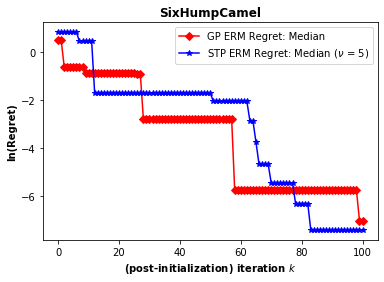

In [149]:
### 8(b). Regret minimisation plot: GP v STP DF 1

title = obj_func

plt.figure()

plt.plot(train_regret_gp_7, label = 'GP ERM Regret: Median', marker = 'D', color = 'Red')
plt.plot(train_regret_stp_df1_5, label = 'STP ERM Regret: Median ' r'($\nu$' ' = {})'.format(df1), marker = '*', color = 'Blue')

plt.title(title, weight = 'bold')
plt.xlabel('(post-initialization) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise

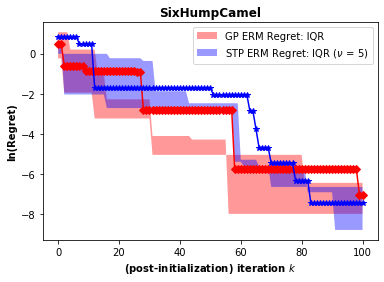

In [150]:
### 8(c). Regret minimisation plot: IQR GP v STP DF 1

title = obj_func

plt.figure()

plt.plot(train_regret_gp_7, marker = 'D', color = 'Red')
plt.plot(train_regret_stp_df1_5, marker = '*', color = 'Blue')

xstar = np.arange(0, 101, step=1)
plt.fill_between(xstar, train_regret_gp_14, train_regret_gp_17, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, train_regret_stp_df1_3, train_regret_stp_df1_7, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df1))

plt.title(title, weight = 'bold')
plt.xlabel('(post-initialization) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise

In [489]:
# Iteration1 :

slice1 = 0

gp1 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp1 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp1_results = pd.DataFrame(gp1).sort_values(by=[0], ascending=False)
stp1_results = pd.DataFrame(stp1).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp1 = np.asarray(gp1_results[4:5][0])[0]
median_gp1 = np.asarray(gp1_results[9:10][0])[0]
upper_gp1 = np.asarray(gp1_results[14:15][0])[0]

lower_stp1 = np.asarray(stp1_results[4:5][0])[0]
median_stp1 = np.asarray(stp1_results[9:10][0])[0]
upper_stp1 = np.asarray(stp1_results[14:15][0])[0]

lower_gp1, median_gp1, upper_gp1, lower_stp1, median_stp1, upper_stp1


(1.453170815272413,
 0.932583227627826,
 0.2205341068195849,
 1.453170815272413,
 0.932583227627826,
 0.2205341068195849)

In [490]:
# Iteration11 :

slice11 = 10

gp11 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp11 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp11_results = pd.DataFrame(gp11).sort_values(by=[0], ascending=False)
stp11_results = pd.DataFrame(stp11).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp11 = np.asarray(gp11_results[4:5][0])[0]
median_gp11 = np.asarray(gp11_results[9:10][0])[0]
upper_gp11 = np.asarray(gp11_results[14:15][0])[0]

lower_stp11 = np.asarray(stp11_results[4:5][0])[0]
median_stp11 = np.asarray(stp11_results[9:10][0])[0]
upper_stp11 = np.asarray(stp11_results[14:15][0])[0]

lower_gp11, median_gp11, upper_gp11, lower_stp11, median_stp11, upper_stp11


(-0.18574583479583393,
 -1.281852554730428,
 -1.9392242470871357,
 0.45661910965152,
 0.20298679641378103,
 -0.2503205918108705)

In [491]:
# Iteration21 :

slice21 = 20

gp21 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp21 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp21_results = pd.DataFrame(gp21).sort_values(by=[0], ascending=False)
stp21_results = pd.DataFrame(stp21).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp21 = np.asarray(gp21_results[4:5][0])[0]
median_gp21 = np.asarray(gp21_results[9:10][0])[0]
upper_gp21 = np.asarray(gp21_results[14:15][0])[0]

lower_stp21 = np.asarray(stp21_results[4:5][0])[0]
median_stp21 = np.asarray(stp21_results[9:10][0])[0]
upper_stp21 = np.asarray(stp21_results[14:15][0])[0]

lower_gp21, median_gp21, upper_gp21, lower_stp21, median_stp21, upper_stp21


(-2.013085997393315,
 -2.2747938586831666,
 -3.567735794938741,
 -0.43410181958144467,
 -0.9847074607347619,
 -1.9536858526963758)

In [492]:
# Iteration31 :

slice31 = 30

gp31 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp31 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp31_results = pd.DataFrame(gp31).sort_values(by=[0], ascending=False)
stp31_results = pd.DataFrame(stp31).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp31 = np.asarray(gp31_results[4:5][0])[0]
median_gp31 = np.asarray(gp31_results[9:10][0])[0]
upper_gp31 = np.asarray(gp31_results[14:15][0])[0]

lower_stp31 = np.asarray(stp31_results[4:5][0])[0]
median_stp31 = np.asarray(stp31_results[9:10][0])[0]
upper_stp31 = np.asarray(stp31_results[14:15][0])[0]

lower_gp31, median_gp31, upper_gp31, lower_stp31, median_stp31, upper_stp31


(-3.0769829970776734,
 -3.567735794938741,
 -4.784946696880455,
 -1.1894626716130274,
 -1.84267799242898,
 -2.954558557712974)

In [493]:
# Iteration41 :

slice41 = 40

gp41 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp41 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp41_results = pd.DataFrame(gp41).sort_values(by=[0], ascending=False)
stp41_results = pd.DataFrame(stp41).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp41 = np.asarray(gp41_results[4:5][0])[0]
median_gp41 = np.asarray(gp41_results[9:10][0])[0]
upper_gp41 = np.asarray(gp41_results[14:15][0])[0]

lower_stp41 = np.asarray(stp41_results[4:5][0])[0]
median_stp41 = np.asarray(stp41_results[9:10][0])[0]
upper_stp41 = np.asarray(stp41_results[14:15][0])[0]

lower_gp41, median_gp41, upper_gp41, lower_stp41, median_stp41, upper_stp41


(-3.5328519604015534,
 -4.329036256882474,
 -6.085550974184749,
 -1.3725104883580868,
 -2.14573800025984,
 -3.1027977473374513)

In [494]:
# Iteration51 :

slice51 = 50

gp51 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp51 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp51_results = pd.DataFrame(gp51).sort_values(by=[0], ascending=False)
stp51_results = pd.DataFrame(stp51).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp51 = np.asarray(gp51_results[4:5][0])[0]
median_gp51 = np.asarray(gp51_results[9:10][0])[0]
upper_gp51 = np.asarray(gp51_results[14:15][0])[0]

lower_stp51 = np.asarray(stp51_results[4:5][0])[0]
median_stp51 = np.asarray(stp51_results[9:10][0])[0]
upper_stp51 = np.asarray(stp51_results[14:15][0])[0]

lower_gp51, median_gp51, upper_gp51, lower_stp51, median_stp51, upper_stp51


(-3.7512393232368244,
 -4.983037282468382,
 -6.512649538397736,
 -1.84267799242898,
 -2.7098704090117267,
 -3.1401899289982773)

In [495]:
# Iteration61 :

slice61 = 60

gp61 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp61 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp61_results = pd.DataFrame(gp61).sort_values(by=[0], ascending=False)
stp61_results = pd.DataFrame(stp61).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp61 = np.asarray(gp61_results[4:5][0])[0]
median_gp61 = np.asarray(gp61_results[9:10][0])[0]
upper_gp61 = np.asarray(gp61_results[14:15][0])[0]

lower_stp61 = np.asarray(stp61_results[4:5][0])[0]
median_stp61 = np.asarray(stp61_results[9:10][0])[0]
upper_stp61 = np.asarray(stp61_results[14:15][0])[0]

lower_gp61, median_gp61, upper_gp61, lower_stp61, median_stp61, upper_stp61


(-4.983037282468382,
 -5.809000589194058,
 -6.824744002284245,
 -2.954558557712974,
 -3.7236168929840363,
 -5.279426808928781)

In [496]:
# Iteration71 :

slice71 = 70

gp71 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp71 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp71_results = pd.DataFrame(gp71).sort_values(by=[0], ascending=False)
stp71_results = pd.DataFrame(stp71).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp71 = np.asarray(gp71_results[4:5][0])[0]
median_gp71 = np.asarray(gp71_results[9:10][0])[0]
upper_gp71 = np.asarray(gp71_results[14:15][0])[0]

lower_stp71 = np.asarray(stp71_results[4:5][0])[0]
median_stp71 = np.asarray(stp71_results[9:10][0])[0]
upper_stp71 = np.asarray(stp71_results[14:15][0])[0]

lower_gp71, median_gp71, upper_gp71, lower_stp71, median_stp71, upper_stp71


(-5.034759677296762,
 -6.053350161324649,
 -7.188855437458066,
 -5.674642959152586,
 -6.445675885433328,
 -6.782682110683666)

In [497]:
# Iteration81 :

slice81 = 80

gp81 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp81 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp81_results = pd.DataFrame(gp81).sort_values(by=[0], ascending=False)
stp81_results = pd.DataFrame(stp81).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp81 = np.asarray(gp81_results[4:5][0])[0]
median_gp81 = np.asarray(gp81_results[9:10][0])[0]
upper_gp81 = np.asarray(gp81_results[14:15][0])[0]

lower_stp81 = np.asarray(stp81_results[4:5][0])[0]
median_stp81 = np.asarray(stp81_results[9:10][0])[0]
upper_stp81 = np.asarray(stp81_results[14:15][0])[0]

lower_gp81, median_gp81, upper_gp81, lower_stp81, median_stp81, upper_stp81

(-5.346452056822993,
 -6.451728156644326,
 -7.800841090559586,
 -6.315929342219681,
 -6.782682110683666,
 -8.403064768818009)

In [498]:
# Iteration91 :

slice1 = 90

gp91 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp91 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp91_results = pd.DataFrame(gp91).sort_values(by=[0], ascending=False)
stp91_results = pd.DataFrame(stp91).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp91 = np.asarray(gp91_results[4:5][0])[0]
median_gp91 = np.asarray(gp91_results[9:10][0])[0]
upper_gp91 = np.asarray(gp91_results[14:15][0])[0]

lower_stp91 = np.asarray(stp91_results[4:5][0])[0]
median_stp91 = np.asarray(stp91_results[9:10][0])[0]
upper_stp91 = np.asarray(stp91_results[14:15][0])[0]

lower_gp91, median_gp91, upper_gp91, lower_stp91, median_stp91, upper_stp91


(-6.053350161324649,
 -6.708104661818667,
 -7.928203586916229,
 -6.671442029397026,
 -7.418907526359189,
 -8.403064768818009)

In [499]:
# Iteration101 :

slice1 = 100

gp101 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp101 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp101_results = pd.DataFrame(gp101).sort_values(by=[0], ascending=False)
stp101_results = pd.DataFrame(stp101).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp101 = np.asarray(gp101_results[4:5][0])[0]
median_gp101 = np.asarray(gp101_results[9:10][0])[0]
upper_gp101 = np.asarray(gp101_results[14:15][0])[0]

lower_stp101 = np.asarray(stp101_results[4:5][0])[0]
median_stp101 = np.asarray(stp101_results[9:10][0])[0]
upper_stp101 = np.asarray(stp101_results[14:15][0])[0]

lower_gp101, median_gp101, upper_gp101, lower_stp101, median_stp101, upper_stp101


(-6.428621848660673,
 -7.035995711203121,
 -7.970378024819956,
 -6.671442029397026,
 -7.880139912603991,
 -9.21851242614693)

In [500]:
# Iteration2 :

slice1 = 1

gp2 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp2 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp2_results = pd.DataFrame(gp2).sort_values(by=[0], ascending=False)
stp2_results = pd.DataFrame(stp2).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp2 = np.asarray(gp2_results[4:5][0])[0]
median_gp2 = np.asarray(gp2_results[9:10][0])[0]
upper_gp2 = np.asarray(gp2_results[14:15][0])[0]

lower_stp2 = np.asarray(stp2_results[4:5][0])[0]
median_stp2 = np.asarray(stp2_results[9:10][0])[0]
upper_stp2 = np.asarray(stp2_results[14:15][0])[0]


In [501]:
# Iteration12 :

slice11 = 11

gp12 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp12 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp12_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp12_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp12 = np.asarray(gp12_results[4:5][0])[0]
median_gp12 = np.asarray(gp12_results[9:10][0])[0]
upper_gp12 = np.asarray(gp12_results[14:15][0])[0]

lower_stp12 = np.asarray(stp12_results[4:5][0])[0]
median_stp12 = np.asarray(stp12_results[9:10][0])[0]
upper_stp12 = np.asarray(stp12_results[14:15][0])[0]


In [502]:
# Iteration22 :

slice21 = 21

gp22 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp22 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp22_results = pd.DataFrame(gp22).sort_values(by=[0], ascending=False)
stp22_results = pd.DataFrame(stp22).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp22 = np.asarray(gp22_results[4:5][0])[0]
median_gp22 = np.asarray(gp22_results[9:10][0])[0]
upper_gp22 = np.asarray(gp22_results[14:15][0])[0]

lower_stp22 = np.asarray(stp22_results[4:5][0])[0]
median_stp22 = np.asarray(stp22_results[9:10][0])[0]
upper_stp22 = np.asarray(stp22_results[14:15][0])[0]


In [503]:
# Iteration32 :

slice31 = 31

gp32 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp32 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp32_results = pd.DataFrame(gp32).sort_values(by=[0], ascending=False)
stp32_results = pd.DataFrame(stp32).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp32 = np.asarray(gp32_results[4:5][0])[0]
median_gp32 = np.asarray(gp32_results[9:10][0])[0]
upper_gp32 = np.asarray(gp32_results[14:15][0])[0]

lower_stp32 = np.asarray(stp32_results[4:5][0])[0]
median_stp32 = np.asarray(stp32_results[9:10][0])[0]
upper_stp32 = np.asarray(stp32_results[14:15][0])[0]


In [504]:
# Iteration42 :

slice41 = 41

gp42 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp42 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp42_results = pd.DataFrame(gp42).sort_values(by=[0], ascending=False)
stp42_results = pd.DataFrame(stp42).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp42 = np.asarray(gp42_results[4:5][0])[0]
median_gp42 = np.asarray(gp42_results[9:10][0])[0]
upper_gp42 = np.asarray(gp42_results[14:15][0])[0]

lower_stp42 = np.asarray(stp42_results[4:5][0])[0]
median_stp42 = np.asarray(stp42_results[9:10][0])[0]
upper_stp42 = np.asarray(stp42_results[14:15][0])[0]


In [505]:
# Iteration52 :

slice51 = 51

gp52 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp52 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp52_results = pd.DataFrame(gp52).sort_values(by=[0], ascending=False)
stp52_results = pd.DataFrame(stp52).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp52 = np.asarray(gp52_results[4:5][0])[0]
median_gp52 = np.asarray(gp52_results[9:10][0])[0]
upper_gp52 = np.asarray(gp52_results[14:15][0])[0]

lower_stp52 = np.asarray(stp52_results[4:5][0])[0]
median_stp52 = np.asarray(stp52_results[9:10][0])[0]
upper_stp52 = np.asarray(stp52_results[14:15][0])[0]


In [506]:
# Iteration62 :

slice61 = 61

gp62 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp62 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp62_results = pd.DataFrame(gp62).sort_values(by=[0], ascending=False)
stp62_results = pd.DataFrame(stp62).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp62 = np.asarray(gp62_results[4:5][0])[0]
median_gp62 = np.asarray(gp62_results[9:10][0])[0]
upper_gp62 = np.asarray(gp62_results[14:15][0])[0]

lower_stp62 = np.asarray(stp62_results[4:5][0])[0]
median_stp62 = np.asarray(stp62_results[9:10][0])[0]
upper_stp62 = np.asarray(stp62_results[14:15][0])[0]


In [507]:
# Iteration72 :

slice71 = 71

gp72 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp72 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp72_results = pd.DataFrame(gp72).sort_values(by=[0], ascending=False)
stp72_results = pd.DataFrame(stp72).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp72 = np.asarray(gp72_results[4:5][0])[0]
median_gp72 = np.asarray(gp72_results[9:10][0])[0]
upper_gp72 = np.asarray(gp72_results[14:15][0])[0]

lower_stp72 = np.asarray(stp72_results[4:5][0])[0]
median_stp72 = np.asarray(stp72_results[9:10][0])[0]
upper_stp72 = np.asarray(stp72_results[14:15][0])[0]


In [508]:
# Iteration82 :

slice81 = 81

gp82 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp82 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp82_results = pd.DataFrame(gp82).sort_values(by=[0], ascending=False)
stp82_results = pd.DataFrame(stp82).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp82 = np.asarray(gp82_results[4:5][0])[0]
median_gp82 = np.asarray(gp82_results[9:10][0])[0]
upper_gp82 = np.asarray(gp82_results[14:15][0])[0]

lower_stp82 = np.asarray(stp82_results[4:5][0])[0]
median_stp82 = np.asarray(stp82_results[9:10][0])[0]
upper_stp82 = np.asarray(stp82_results[14:15][0])[0]


In [509]:
# Iteration92 :

slice1 = 91

gp92 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp92 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp92_results = pd.DataFrame(gp92).sort_values(by=[0], ascending=False)
stp92_results = pd.DataFrame(stp92).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp92 = np.asarray(gp92_results[4:5][0])[0]
median_gp92 = np.asarray(gp92_results[9:10][0])[0]
upper_gp92 = np.asarray(gp92_results[14:15][0])[0]

lower_stp92 = np.asarray(stp92_results[4:5][0])[0]
median_stp92 = np.asarray(stp92_results[9:10][0])[0]
upper_stp92 = np.asarray(stp92_results[14:15][0])[0]



In [510]:
# Iteration3 :

slice1 = 2

gp3 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp3 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp3_results = pd.DataFrame(gp3).sort_values(by=[0], ascending=False)
stp3_results = pd.DataFrame(stp3).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp3 = np.asarray(gp3_results[4:5][0])[0]
median_gp3 = np.asarray(gp3_results[9:10][0])[0]
upper_gp3 = np.asarray(gp3_results[14:15][0])[0]

lower_stp3 = np.asarray(stp3_results[4:5][0])[0]
median_stp3 = np.asarray(stp3_results[9:10][0])[0]
upper_stp3 = np.asarray(stp3_results[14:15][0])[0]


In [511]:
# Iteration13 :

slice11 = 12

gp13 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp13 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp13_results = pd.DataFrame(gp12).sort_values(by=[0], ascending=False)
stp13_results = pd.DataFrame(stp12).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp13 = np.asarray(gp13_results[4:5][0])[0]
median_gp13 = np.asarray(gp13_results[9:10][0])[0]
upper_gp13 = np.asarray(gp13_results[14:15][0])[0]

lower_stp13 = np.asarray(stp13_results[4:5][0])[0]
median_stp13 = np.asarray(stp13_results[9:10][0])[0]
upper_stp13 = np.asarray(stp13_results[14:15][0])[0]


In [512]:
# Iteration23 :

slice21 = 22

gp23 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp23 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp23_results = pd.DataFrame(gp23).sort_values(by=[0], ascending=False)
stp23_results = pd.DataFrame(stp23).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp23 = np.asarray(gp23_results[4:5][0])[0]
median_gp23 = np.asarray(gp23_results[9:10][0])[0]
upper_gp23 = np.asarray(gp23_results[14:15][0])[0]

lower_stp23 = np.asarray(stp23_results[4:5][0])[0]
median_stp23 = np.asarray(stp23_results[9:10][0])[0]
upper_stp23 = np.asarray(stp23_results[14:15][0])[0]


In [513]:
# Iteration33 :

slice31 = 32

gp33 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp33 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp33_results = pd.DataFrame(gp33).sort_values(by=[0], ascending=False)
stp33_results = pd.DataFrame(stp33).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp33 = np.asarray(gp33_results[4:5][0])[0]
median_gp33 = np.asarray(gp33_results[9:10][0])[0]
upper_gp33 = np.asarray(gp33_results[14:15][0])[0]

lower_stp33 = np.asarray(stp33_results[4:5][0])[0]
median_stp33 = np.asarray(stp33_results[9:10][0])[0]
upper_stp33 = np.asarray(stp33_results[14:15][0])[0]


In [514]:
# Iteration43 :

slice41 = 42

gp43 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp43 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp43_results = pd.DataFrame(gp43).sort_values(by=[0], ascending=False)
stp43_results = pd.DataFrame(stp43).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp43 = np.asarray(gp43_results[4:5][0])[0]
median_gp43 = np.asarray(gp43_results[9:10][0])[0]
upper_gp43 = np.asarray(gp43_results[14:15][0])[0]

lower_stp43 = np.asarray(stp43_results[4:5][0])[0]
median_stp43 = np.asarray(stp43_results[9:10][0])[0]
upper_stp43 = np.asarray(stp43_results[14:15][0])[0]


In [515]:
# Iteration53 :

slice51 = 52

gp53 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp53 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp53_results = pd.DataFrame(gp53).sort_values(by=[0], ascending=False)
stp53_results = pd.DataFrame(stp53).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp53 = np.asarray(gp53_results[4:5][0])[0]
median_gp53 = np.asarray(gp53_results[9:10][0])[0]
upper_gp53 = np.asarray(gp53_results[14:15][0])[0]

lower_stp53 = np.asarray(stp53_results[4:5][0])[0]
median_stp53 = np.asarray(stp53_results[9:10][0])[0]
upper_stp53 = np.asarray(stp53_results[14:15][0])[0]


In [516]:
# Iteration63 :

slice61 = 62

gp63 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp63 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp63_results = pd.DataFrame(gp63).sort_values(by=[0], ascending=False)
stp63_results = pd.DataFrame(stp63).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp63 = np.asarray(gp63_results[4:5][0])[0]
median_gp63 = np.asarray(gp63_results[9:10][0])[0]
upper_gp63 = np.asarray(gp63_results[14:15][0])[0]

lower_stp63 = np.asarray(stp63_results[4:5][0])[0]
median_stp63 = np.asarray(stp63_results[9:10][0])[0]
upper_stp63 = np.asarray(stp63_results[14:15][0])[0]


In [517]:
# Iteration73 :

slice71 = 72

gp73 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp73 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp73_results = pd.DataFrame(gp73).sort_values(by=[0], ascending=False)
stp73_results = pd.DataFrame(stp73).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp73 = np.asarray(gp73_results[4:5][0])[0]
median_gp73 = np.asarray(gp73_results[9:10][0])[0]
upper_gp73 = np.asarray(gp73_results[14:15][0])[0]

lower_stp73 = np.asarray(stp73_results[4:5][0])[0]
median_stp73 = np.asarray(stp73_results[9:10][0])[0]
upper_stp73 = np.asarray(stp73_results[14:15][0])[0]


In [518]:
# Iteration83 :

slice81 = 82

gp83 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp83 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp83_results = pd.DataFrame(gp83).sort_values(by=[0], ascending=False)
stp83_results = pd.DataFrame(stp83).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp83 = np.asarray(gp83_results[4:5][0])[0]
median_gp83 = np.asarray(gp83_results[9:10][0])[0]
upper_gp83 = np.asarray(gp83_results[14:15][0])[0]

lower_stp83 = np.asarray(stp83_results[4:5][0])[0]
median_stp83 = np.asarray(stp83_results[9:10][0])[0]
upper_stp83 = np.asarray(stp83_results[14:15][0])[0]


In [519]:
# Iteration93 :

slice1 = 92

gp93 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp93 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp93_results = pd.DataFrame(gp93).sort_values(by=[0], ascending=False)
stp93_results = pd.DataFrame(stp93).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp93 = np.asarray(gp93_results[4:5][0])[0]
median_gp93 = np.asarray(gp93_results[9:10][0])[0]
upper_gp93 = np.asarray(gp93_results[14:15][0])[0]

lower_stp93 = np.asarray(stp93_results[4:5][0])[0]
median_stp93 = np.asarray(stp93_results[9:10][0])[0]
upper_stp93 = np.asarray(stp93_results[14:15][0])[0]



In [520]:
# Iteration4 :

slice1 = 3

gp4 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp4 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp4_results = pd.DataFrame(gp4).sort_values(by=[0], ascending=False)
stp4_results = pd.DataFrame(stp4).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp4 = np.asarray(gp4_results[4:5][0])[0]
median_gp4 = np.asarray(gp4_results[9:10][0])[0]
upper_gp4 = np.asarray(gp4_results[14:15][0])[0]

lower_stp4 = np.asarray(stp4_results[4:5][0])[0]
median_stp4 = np.asarray(stp4_results[9:10][0])[0]
upper_stp4 = np.asarray(stp4_results[14:15][0])[0]


In [521]:
# Iteration14 :

slice11 = 13

gp14 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp14 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp14_results = pd.DataFrame(gp14).sort_values(by=[0], ascending=False)
stp14_results = pd.DataFrame(stp14).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp14 = np.asarray(gp14_results[4:5][0])[0]
median_gp14 = np.asarray(gp14_results[9:10][0])[0]
upper_gp14 = np.asarray(gp14_results[14:15][0])[0]

lower_stp14 = np.asarray(stp14_results[4:5][0])[0]
median_stp14 = np.asarray(stp14_results[9:10][0])[0]
upper_stp14 = np.asarray(stp14_results[14:15][0])[0]


In [522]:
# Iteration24 :

slice21 = 23

gp24 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp24 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp24_results = pd.DataFrame(gp24).sort_values(by=[0], ascending=False)
stp24_results = pd.DataFrame(stp24).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp24 = np.asarray(gp24_results[4:5][0])[0]
median_gp24 = np.asarray(gp24_results[9:10][0])[0]
upper_gp24 = np.asarray(gp24_results[14:15][0])[0]

lower_stp24 = np.asarray(stp24_results[4:5][0])[0]
median_stp24 = np.asarray(stp24_results[9:10][0])[0]
upper_stp24 = np.asarray(stp24_results[14:15][0])[0]


In [523]:
# Iteration34 :

slice31 = 33

gp34 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp34 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp34_results = pd.DataFrame(gp34).sort_values(by=[0], ascending=False)
stp34_results = pd.DataFrame(stp34).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp34 = np.asarray(gp34_results[4:5][0])[0]
median_gp34 = np.asarray(gp34_results[9:10][0])[0]
upper_gp34 = np.asarray(gp34_results[14:15][0])[0]

lower_stp34 = np.asarray(stp34_results[4:5][0])[0]
median_stp34 = np.asarray(stp34_results[9:10][0])[0]
upper_stp34 = np.asarray(stp34_results[14:15][0])[0]


In [524]:
# Iteration44 :

slice41 = 43

gp44 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp44 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp44_results = pd.DataFrame(gp44).sort_values(by=[0], ascending=False)
stp44_results = pd.DataFrame(stp44).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp44 = np.asarray(gp44_results[4:5][0])[0]
median_gp44 = np.asarray(gp44_results[9:10][0])[0]
upper_gp44 = np.asarray(gp44_results[14:15][0])[0]

lower_stp44 = np.asarray(stp44_results[4:5][0])[0]
median_stp44 = np.asarray(stp44_results[9:10][0])[0]
upper_stp44 = np.asarray(stp44_results[14:15][0])[0]


In [525]:
# Iteration54 :

slice51 = 53

gp54 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp54 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp54_results = pd.DataFrame(gp54).sort_values(by=[0], ascending=False)
stp54_results = pd.DataFrame(stp54).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp54 = np.asarray(gp54_results[4:5][0])[0]
median_gp54 = np.asarray(gp54_results[9:10][0])[0]
upper_gp54 = np.asarray(gp54_results[14:15][0])[0]

lower_stp54 = np.asarray(stp54_results[4:5][0])[0]
median_stp54 = np.asarray(stp54_results[9:10][0])[0]
upper_stp54 = np.asarray(stp54_results[14:15][0])[0]


In [526]:
# Iteration64 :

slice61 = 63

gp64 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp64 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp64_results = pd.DataFrame(gp64).sort_values(by=[0], ascending=False)
stp64_results = pd.DataFrame(stp64).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp64 = np.asarray(gp64_results[4:5][0])[0]
median_gp64 = np.asarray(gp64_results[9:10][0])[0]
upper_gp64 = np.asarray(gp64_results[14:15][0])[0]

lower_stp64 = np.asarray(stp64_results[4:5][0])[0]
median_stp64 = np.asarray(stp64_results[9:10][0])[0]
upper_stp64 = np.asarray(stp64_results[14:15][0])[0]


In [527]:
# Iteration74 :

slice71 = 73

gp74 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp74 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp74_results = pd.DataFrame(gp74).sort_values(by=[0], ascending=False)
stp74_results = pd.DataFrame(stp74).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp74 = np.asarray(gp74_results[4:5][0])[0]
median_gp74 = np.asarray(gp74_results[9:10][0])[0]
upper_gp74 = np.asarray(gp74_results[14:15][0])[0]

lower_stp74 = np.asarray(stp74_results[4:5][0])[0]
median_stp74 = np.asarray(stp74_results[9:10][0])[0]
upper_stp74 = np.asarray(stp74_results[14:15][0])[0]


In [528]:
# Iteration84 :

slice81 = 83

gp84 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp84 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp84_results = pd.DataFrame(gp84).sort_values(by=[0], ascending=False)
stp84_results = pd.DataFrame(stp84).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp84 = np.asarray(gp84_results[4:5][0])[0]
median_gp84 = np.asarray(gp84_results[9:10][0])[0]
upper_gp84 = np.asarray(gp84_results[14:15][0])[0]

lower_stp84 = np.asarray(stp84_results[4:5][0])[0]
median_stp84 = np.asarray(stp84_results[9:10][0])[0]
upper_stp84 = np.asarray(stp84_results[14:15][0])[0]


In [529]:
# Iteration94 :

slice1 = 93

gp94 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp94 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp94_results = pd.DataFrame(gp94).sort_values(by=[0], ascending=False)
stp94_results = pd.DataFrame(stp94).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp94 = np.asarray(gp94_results[4:5][0])[0]
median_gp94 = np.asarray(gp94_results[9:10][0])[0]
upper_gp94 = np.asarray(gp94_results[14:15][0])[0]

lower_stp94 = np.asarray(stp94_results[4:5][0])[0]
median_stp94 = np.asarray(stp94_results[9:10][0])[0]
upper_stp94 = np.asarray(stp94_results[14:15][0])[0]



In [530]:
# Iteration5 :

slice1 = 4

gp5 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp5 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp5_results = pd.DataFrame(gp5).sort_values(by=[0], ascending=False)
stp5_results = pd.DataFrame(stp5).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp5 = np.asarray(gp5_results[4:5][0])[0]
median_gp5 = np.asarray(gp5_results[9:10][0])[0]
upper_gp5 = np.asarray(gp5_results[14:15][0])[0]

lower_stp5 = np.asarray(stp5_results[4:5][0])[0]
median_stp5 = np.asarray(stp5_results[9:10][0])[0]
upper_stp5 = np.asarray(stp5_results[14:15][0])[0]


In [531]:
# Iteration15 :

slice11 = 14

gp15 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp15 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp15_results = pd.DataFrame(gp15).sort_values(by=[0], ascending=False)
stp15_results = pd.DataFrame(stp15).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp15 = np.asarray(gp15_results[4:5][0])[0]
median_gp15 = np.asarray(gp15_results[9:10][0])[0]
upper_gp15 = np.asarray(gp15_results[14:15][0])[0]

lower_stp15 = np.asarray(stp15_results[4:5][0])[0]
median_stp15 = np.asarray(stp15_results[9:10][0])[0]
upper_stp15 = np.asarray(stp15_results[14:15][0])[0]


In [532]:
# Iteration25 :

slice21 = 24

gp25 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp25 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp25_results = pd.DataFrame(gp25).sort_values(by=[0], ascending=False)
stp25_results = pd.DataFrame(stp25).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp25 = np.asarray(gp25_results[4:5][0])[0]
median_gp25 = np.asarray(gp25_results[9:10][0])[0]
upper_gp25 = np.asarray(gp25_results[14:15][0])[0]

lower_stp25 = np.asarray(stp25_results[4:5][0])[0]
median_stp25 = np.asarray(stp25_results[9:10][0])[0]
upper_stp25= np.asarray(stp25_results[14:15][0])[0]


In [533]:
# Iteration35 :

slice31 = 34

gp35 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp35 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp35_results = pd.DataFrame(gp35).sort_values(by=[0], ascending=False)
stp35_results = pd.DataFrame(stp35).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp35 = np.asarray(gp35_results[4:5][0])[0]
median_gp35 = np.asarray(gp35_results[9:10][0])[0]
upper_gp35 = np.asarray(gp35_results[14:15][0])[0]

lower_stp35 = np.asarray(stp35_results[4:5][0])[0]
median_stp35 = np.asarray(stp35_results[9:10][0])[0]
upper_stp35 = np.asarray(stp35_results[14:15][0])[0]


In [534]:
# Iteration45 :

slice41 = 44

gp45 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp45 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp45_results = pd.DataFrame(gp45).sort_values(by=[0], ascending=False)
stp45_results = pd.DataFrame(stp45).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp45 = np.asarray(gp45_results[4:5][0])[0]
median_gp45 = np.asarray(gp45_results[9:10][0])[0]
upper_gp45 = np.asarray(gp45_results[14:15][0])[0]

lower_stp45 = np.asarray(stp45_results[4:5][0])[0]
median_stp45 = np.asarray(stp45_results[9:10][0])[0]
upper_stp45 = np.asarray(stp45_results[14:15][0])[0]


In [535]:
# Iteration55 :

slice51 = 54

gp55 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp55 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp55_results = pd.DataFrame(gp55).sort_values(by=[0], ascending=False)
stp55_results = pd.DataFrame(stp55).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp55 = np.asarray(gp55_results[4:5][0])[0]
median_gp55 = np.asarray(gp55_results[9:10][0])[0]
upper_gp55 = np.asarray(gp55_results[14:15][0])[0]

lower_stp55 = np.asarray(stp55_results[4:5][0])[0]
median_stp55 = np.asarray(stp55_results[9:10][0])[0]
upper_stp55 = np.asarray(stp55_results[14:15][0])[0]


In [536]:
# Iteration65 :

slice61 = 64

gp65 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp65 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp65_results = pd.DataFrame(gp65).sort_values(by=[0], ascending=False)
stp65_results = pd.DataFrame(stp65).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp65 = np.asarray(gp65_results[4:5][0])[0]
median_gp65 = np.asarray(gp65_results[9:10][0])[0]
upper_gp65 = np.asarray(gp65_results[14:15][0])[0]

lower_stp65 = np.asarray(stp65_results[4:5][0])[0]
median_stp65 = np.asarray(stp65_results[9:10][0])[0]
upper_stp65 = np.asarray(stp65_results[14:15][0])[0]


In [537]:
# Iteration75 :

slice71 = 74

gp75 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp75 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp75_results = pd.DataFrame(gp75).sort_values(by=[0], ascending=False)
stp75_results = pd.DataFrame(stp75).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp75 = np.asarray(gp75_results[4:5][0])[0]
median_gp75 = np.asarray(gp75_results[9:10][0])[0]
upper_gp75 = np.asarray(gp75_results[14:15][0])[0]

lower_stp75 = np.asarray(stp75_results[4:5][0])[0]
median_stp75 = np.asarray(stp75_results[9:10][0])[0]
upper_stp75 = np.asarray(stp75_results[14:15][0])[0]


In [538]:
# Iteration85 :

slice81 = 84

gp85 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp85 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp85_results = pd.DataFrame(gp85).sort_values(by=[0], ascending=False)
stp85_results = pd.DataFrame(stp85).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp85 = np.asarray(gp85_results[4:5][0])[0]
median_gp85 = np.asarray(gp85_results[9:10][0])[0]
upper_gp85 = np.asarray(gp85_results[14:15][0])[0]

lower_stp85 = np.asarray(stp85_results[4:5][0])[0]
median_stp85 = np.asarray(stp85_results[9:10][0])[0]
upper_stp85 = np.asarray(stp85_results[14:15][0])[0]


In [539]:
# Iteration95 :

slice1 = 94

gp95 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp95 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp95_results = pd.DataFrame(gp95).sort_values(by=[0], ascending=False)
stp95_results = pd.DataFrame(stp95).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp95 = np.asarray(gp95_results[4:5][0])[0]
median_gp95 = np.asarray(gp95_results[9:10][0])[0]
upper_gp95 = np.asarray(gp95_results[14:15][0])[0]

lower_stp95 = np.asarray(stp95_results[4:5][0])[0]
median_stp95 = np.asarray(stp95_results[9:10][0])[0]
upper_stp95 = np.asarray(stp95_results[14:15][0])[0]



In [540]:
# Iteration6 :

slice1 = 5

gp6 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp6 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp6_results = pd.DataFrame(gp6).sort_values(by=[0], ascending=False)
stp6_results = pd.DataFrame(stp6).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp6 = np.asarray(gp6_results[4:5][0])[0]
median_gp6 = np.asarray(gp6_results[9:10][0])[0]
upper_gp6 = np.asarray(gp6_results[14:15][0])[0]

lower_stp6 = np.asarray(stp6_results[4:5][0])[0]
median_stp6 = np.asarray(stp6_results[9:10][0])[0]
upper_stp6 = np.asarray(stp6_results[14:15][0])[0]


In [541]:
# Iteration16 :

slice11 = 15

gp16 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp16 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp16_results = pd.DataFrame(gp16).sort_values(by=[0], ascending=False)
stp16_results = pd.DataFrame(stp16).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp16 = np.asarray(gp16_results[4:5][0])[0]
median_gp16 = np.asarray(gp16_results[9:10][0])[0]
upper_gp16 = np.asarray(gp16_results[14:15][0])[0]

lower_stp16 = np.asarray(stp16_results[4:5][0])[0]
median_stp16 = np.asarray(stp16_results[9:10][0])[0]
upper_stp16 = np.asarray(stp16_results[14:15][0])[0]


In [542]:
# Iteration26 :

slice21 = 25

gp26 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp26 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp26_results = pd.DataFrame(gp26).sort_values(by=[0], ascending=False)
stp26_results = pd.DataFrame(stp26).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp26 = np.asarray(gp26_results[4:5][0])[0]
median_gp26 = np.asarray(gp26_results[9:10][0])[0]
upper_gp26 = np.asarray(gp26_results[14:15][0])[0]

lower_stp26 = np.asarray(stp26_results[4:5][0])[0]
median_stp26 = np.asarray(stp26_results[9:10][0])[0]
upper_stp26 = np.asarray(stp26_results[14:15][0])[0]


In [543]:
# Iteration36 :

slice31 = 35

gp36 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp36 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp36_results = pd.DataFrame(gp36).sort_values(by=[0], ascending=False)
stp36_results = pd.DataFrame(stp36).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp36 = np.asarray(gp36_results[4:5][0])[0]
median_gp36 = np.asarray(gp36_results[9:10][0])[0]
upper_gp36 = np.asarray(gp36_results[14:15][0])[0]

lower_stp36 = np.asarray(stp36_results[4:5][0])[0]
median_stp36 = np.asarray(stp36_results[9:10][0])[0]
upper_stp36 = np.asarray(stp36_results[14:15][0])[0]


In [544]:
# Iteration46 :

slice41 = 45

gp46 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp46 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp46_results = pd.DataFrame(gp46).sort_values(by=[0], ascending=False)
stp46_results = pd.DataFrame(stp46).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp46 = np.asarray(gp46_results[4:5][0])[0]
median_gp46 = np.asarray(gp46_results[9:10][0])[0]
upper_gp46 = np.asarray(gp46_results[14:15][0])[0]

lower_stp46 = np.asarray(stp46_results[4:5][0])[0]
median_stp46 = np.asarray(stp46_results[9:10][0])[0]
upper_stp46 = np.asarray(stp46_results[14:15][0])[0]


In [545]:
# Iteration56 :

slice51 = 55

gp56 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp56 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp56_results = pd.DataFrame(gp56).sort_values(by=[0], ascending=False)
stp56_results = pd.DataFrame(stp56).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp56 = np.asarray(gp56_results[4:5][0])[0]
median_gp56 = np.asarray(gp56_results[9:10][0])[0]
upper_gp56 = np.asarray(gp56_results[14:15][0])[0]

lower_stp56 = np.asarray(stp56_results[4:5][0])[0]
median_stp56 = np.asarray(stp56_results[9:10][0])[0]
upper_stp56 = np.asarray(stp56_results[14:15][0])[0]


In [546]:
# Iteration66 :

slice61 = 65

gp66 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp66 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp66_results = pd.DataFrame(gp66).sort_values(by=[0], ascending=False)
stp66_results = pd.DataFrame(stp66).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp66 = np.asarray(gp66_results[4:5][0])[0]
median_gp66 = np.asarray(gp66_results[9:10][0])[0]
upper_gp66 = np.asarray(gp66_results[14:15][0])[0]

lower_stp66 = np.asarray(stp66_results[4:5][0])[0]
median_stp66 = np.asarray(stp66_results[9:10][0])[0]
upper_stp66 = np.asarray(stp66_results[14:15][0])[0]


In [547]:
# Iteration76 :

slice71 = 75

gp76 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp76 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp76_results = pd.DataFrame(gp76).sort_values(by=[0], ascending=False)
stp76_results = pd.DataFrame(stp76).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp76 = np.asarray(gp76_results[4:5][0])[0]
median_gp76 = np.asarray(gp76_results[9:10][0])[0]
upper_gp76 = np.asarray(gp76_results[14:15][0])[0]

lower_stp76 = np.asarray(stp76_results[4:5][0])[0]
median_stp76 = np.asarray(stp76_results[9:10][0])[0]
upper_stp76 = np.asarray(stp76_results[14:15][0])[0]


In [548]:
# Iteration86 :

slice81 = 85

gp86 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp86 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp86_results = pd.DataFrame(gp86).sort_values(by=[0], ascending=False)
stp86_results = pd.DataFrame(stp86).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp86 = np.asarray(gp86_results[4:5][0])[0]
median_gp86 = np.asarray(gp86_results[9:10][0])[0]
upper_gp86 = np.asarray(gp86_results[14:15][0])[0]

lower_stp86 = np.asarray(stp86_results[4:5][0])[0]
median_stp86 = np.asarray(stp86_results[9:10][0])[0]
upper_stp86 = np.asarray(stp86_results[14:15][0])[0]


In [549]:
# Iteration96 :

slice1 = 95

gp96 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp96 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp96_results = pd.DataFrame(gp96).sort_values(by=[0], ascending=False)
stp96_results = pd.DataFrame(stp96).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp96 = np.asarray(gp96_results[4:5][0])[0]
median_gp96 = np.asarray(gp96_results[9:10][0])[0]
upper_gp96 = np.asarray(gp96_results[14:15][0])[0]

lower_stp96 = np.asarray(stp96_results[4:5][0])[0]
median_stp96 = np.asarray(stp96_results[9:10][0])[0]
upper_stp96 = np.asarray(stp96_results[14:15][0])[0]



In [550]:
# Iteration7 :

slice1 = 6

gp7 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp7 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp7_results = pd.DataFrame(gp7).sort_values(by=[0], ascending=False)
stp7_results = pd.DataFrame(stp7).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp7 = np.asarray(gp7_results[4:5][0])[0]
median_gp7 = np.asarray(gp7_results[9:10][0])[0]
upper_gp7 = np.asarray(gp7_results[14:15][0])[0]

lower_stp7 = np.asarray(stp7_results[4:5][0])[0]
median_stp7 = np.asarray(stp7_results[9:10][0])[0]
upper_stp7 = np.asarray(stp7_results[14:15][0])[0]


In [551]:
# Iteration17 :

slice11 = 16

gp17 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp17 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp17_results = pd.DataFrame(gp17).sort_values(by=[0], ascending=False)
stp17_results = pd.DataFrame(stp17).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp17 = np.asarray(gp17_results[4:5][0])[0]
median_gp17 = np.asarray(gp17_results[9:10][0])[0]
upper_gp17 = np.asarray(gp17_results[14:15][0])[0]

lower_stp17 = np.asarray(stp17_results[4:5][0])[0]
median_stp17 = np.asarray(stp17_results[9:10][0])[0]
upper_stp17 = np.asarray(stp17_results[14:15][0])[0]


In [552]:
# Iteration27 :

slice21 = 26

gp27 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp27 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp27_results = pd.DataFrame(gp27).sort_values(by=[0], ascending=False)
stp27_results = pd.DataFrame(stp27).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp27 = np.asarray(gp27_results[4:5][0])[0]
median_gp27 = np.asarray(gp27_results[9:10][0])[0]
upper_gp27 = np.asarray(gp27_results[14:15][0])[0]

lower_stp27 = np.asarray(stp27_results[4:5][0])[0]
median_stp27 = np.asarray(stp27_results[9:10][0])[0]
upper_stp27 = np.asarray(stp27_results[14:15][0])[0]


In [553]:
# Iteration37 :

slice31 = 36

gp37 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp37 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp37_results = pd.DataFrame(gp37).sort_values(by=[0], ascending=False)
stp37_results = pd.DataFrame(stp37).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp37 = np.asarray(gp37_results[4:5][0])[0]
median_gp37 = np.asarray(gp37_results[9:10][0])[0]
upper_gp37 = np.asarray(gp37_results[14:15][0])[0]

lower_stp37 = np.asarray(stp37_results[4:5][0])[0]
median_stp37 = np.asarray(stp37_results[9:10][0])[0]
upper_stp37 = np.asarray(stp37_results[14:15][0])[0]


In [554]:
# Iteration47 :

slice41 = 46

gp47 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp47 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp47_results = pd.DataFrame(gp47).sort_values(by=[0], ascending=False)
stp47_results = pd.DataFrame(stp47).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp47 = np.asarray(gp47_results[4:5][0])[0]
median_gp47 = np.asarray(gp47_results[9:10][0])[0]
upper_gp47 = np.asarray(gp47_results[14:15][0])[0]

lower_stp47 = np.asarray(stp47_results[4:5][0])[0]
median_stp47 = np.asarray(stp47_results[9:10][0])[0]
upper_stp47 = np.asarray(stp47_results[14:15][0])[0]


In [555]:
# Iteration57 :

slice51 = 56

gp57 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp57 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp57_results = pd.DataFrame(gp57).sort_values(by=[0], ascending=False)
stp57_results = pd.DataFrame(stp57).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp57 = np.asarray(gp57_results[4:5][0])[0]
median_gp57 = np.asarray(gp57_results[9:10][0])[0]
upper_gp57 = np.asarray(gp57_results[14:15][0])[0]

lower_stp57 = np.asarray(stp57_results[4:5][0])[0]
median_stp57 = np.asarray(stp57_results[9:10][0])[0]
upper_stp57 = np.asarray(stp57_results[14:15][0])[0]


In [556]:
# Iteration67 :

slice61 = 66

gp67 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp67 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp67_results = pd.DataFrame(gp67).sort_values(by=[0], ascending=False)
stp67_results = pd.DataFrame(stp67).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp67 = np.asarray(gp67_results[4:5][0])[0]
median_gp67 = np.asarray(gp67_results[9:10][0])[0]
upper_gp67 = np.asarray(gp67_results[14:15][0])[0]

lower_stp67 = np.asarray(stp67_results[4:5][0])[0]
median_stp67 = np.asarray(stp67_results[9:10][0])[0]
upper_stp67 = np.asarray(stp67_results[14:15][0])[0]


In [557]:
# Iteration77 :

slice71 = 76

gp77 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp77 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp77_results = pd.DataFrame(gp77).sort_values(by=[0], ascending=False)
stp77_results = pd.DataFrame(stp77).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp77 = np.asarray(gp77_results[4:5][0])[0]
median_gp77 = np.asarray(gp77_results[9:10][0])[0]
upper_gp77 = np.asarray(gp77_results[14:15][0])[0]

lower_stp77 = np.asarray(stp77_results[4:5][0])[0]
median_stp77 = np.asarray(stp77_results[9:10][0])[0]
upper_stp77 = np.asarray(stp77_results[14:15][0])[0]


In [558]:
# Iteration87 :

slice81 = 86

gp87 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp87 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp87_results = pd.DataFrame(gp87).sort_values(by=[0], ascending=False)
stp87_results = pd.DataFrame(stp87).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp87 = np.asarray(gp87_results[4:5][0])[0]
median_gp87 = np.asarray(gp87_results[9:10][0])[0]
upper_gp87 = np.asarray(gp87_results[14:15][0])[0]

lower_stp87 = np.asarray(stp87_results[4:5][0])[0]
median_stp87 = np.asarray(stp87_results[9:10][0])[0]
upper_stp87 = np.asarray(stp87_results[14:15][0])[0]


In [559]:
# Iteration97 :

slice1 = 96

gp97 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp97 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp97_results = pd.DataFrame(gp97).sort_values(by=[0], ascending=False)
stp97_results = pd.DataFrame(stp97).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp97 = np.asarray(gp97_results[4:5][0])[0]
median_gp97 = np.asarray(gp97_results[9:10][0])[0]
upper_gp97 = np.asarray(gp97_results[14:15][0])[0]

lower_stp97 = np.asarray(stp97_results[4:5][0])[0]
median_stp97 = np.asarray(stp97_results[9:10][0])[0]
upper_stp97 = np.asarray(stp97_results[14:15][0])[0]



In [560]:
# Iteration8 :

slice1 = 7

gp8 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp8 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp8_results = pd.DataFrame(gp8).sort_values(by=[0], ascending=False)
stp8_results = pd.DataFrame(stp8).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp8 = np.asarray(gp8_results[4:5][0])[0]
median_gp8 = np.asarray(gp8_results[9:10][0])[0]
upper_gp8 = np.asarray(gp8_results[14:15][0])[0]

lower_stp8 = np.asarray(stp8_results[4:5][0])[0]
median_stp8 = np.asarray(stp8_results[9:10][0])[0]
upper_stp8 = np.asarray(stp8_results[14:15][0])[0]


In [561]:
# Iteration18 :

slice11 = 17

gp18 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp18 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp18_results = pd.DataFrame(gp18).sort_values(by=[0], ascending=False)
stp18_results = pd.DataFrame(stp18).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp18 = np.asarray(gp18_results[4:5][0])[0]
median_gp18 = np.asarray(gp18_results[9:10][0])[0]
upper_gp18 = np.asarray(gp18_results[14:15][0])[0]

lower_stp18 = np.asarray(stp18_results[4:5][0])[0]
median_stp18 = np.asarray(stp18_results[9:10][0])[0]
upper_stp18 = np.asarray(stp18_results[14:15][0])[0]


In [562]:
# Iteration28 :

slice21 = 27

gp28 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp28 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp28_results = pd.DataFrame(gp28).sort_values(by=[0], ascending=False)
stp28_results = pd.DataFrame(stp28).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp28 = np.asarray(gp28_results[4:5][0])[0]
median_gp28 = np.asarray(gp28_results[9:10][0])[0]
upper_gp28 = np.asarray(gp28_results[14:15][0])[0]

lower_stp28 = np.asarray(stp28_results[4:5][0])[0]
median_stp28 = np.asarray(stp28_results[9:10][0])[0]
upper_stp28 = np.asarray(stp28_results[14:15][0])[0]


In [563]:
# Iteration38 :

slice31 = 37

gp38 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp38 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp38_results = pd.DataFrame(gp38).sort_values(by=[0], ascending=False)
stp38_results = pd.DataFrame(stp38).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp38 = np.asarray(gp38_results[4:5][0])[0]
median_gp38 = np.asarray(gp38_results[9:10][0])[0]
upper_gp38 = np.asarray(gp38_results[14:15][0])[0]

lower_stp38 = np.asarray(stp38_results[4:5][0])[0]
median_stp38 = np.asarray(stp38_results[9:10][0])[0]
upper_stp38 = np.asarray(stp38_results[14:15][0])[0]


In [564]:
# Iteration48 :

slice41 = 47

gp48 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp48 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp48_results = pd.DataFrame(gp48).sort_values(by=[0], ascending=False)
stp48_results = pd.DataFrame(stp48).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp48 = np.asarray(gp48_results[4:5][0])[0]
median_gp48 = np.asarray(gp48_results[9:10][0])[0]
upper_gp48 = np.asarray(gp48_results[14:15][0])[0]

lower_stp48 = np.asarray(stp48_results[4:5][0])[0]
median_stp48 = np.asarray(stp48_results[9:10][0])[0]
upper_stp48 = np.asarray(stp48_results[14:15][0])[0]


In [565]:
# Iteration58 :

slice51 = 57

gp58 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp58 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp58_results = pd.DataFrame(gp58).sort_values(by=[0], ascending=False)
stp58_results = pd.DataFrame(stp58).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp58 = np.asarray(gp58_results[4:5][0])[0]
median_gp58 = np.asarray(gp58_results[9:10][0])[0]
upper_gp58 = np.asarray(gp58_results[14:15][0])[0]

lower_stp58 = np.asarray(stp58_results[4:5][0])[0]
median_stp58 = np.asarray(stp58_results[9:10][0])[0]
upper_stp58 = np.asarray(stp58_results[14:15][0])[0]


In [566]:
# Iteration68 :

slice61 = 67

gp68 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp68 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp68_results = pd.DataFrame(gp68).sort_values(by=[0], ascending=False)
stp68_results = pd.DataFrame(stp68).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp68 = np.asarray(gp68_results[4:5][0])[0]
median_gp68 = np.asarray(gp68_results[9:10][0])[0]
upper_gp68 = np.asarray(gp68_results[14:15][0])[0]

lower_stp68 = np.asarray(stp68_results[4:5][0])[0]
median_stp68 = np.asarray(stp68_results[9:10][0])[0]
upper_stp68 = np.asarray(stp68_results[14:15][0])[0]


In [567]:
# Iteration78 :

slice71 = 77

gp78 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp78 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp78_results = pd.DataFrame(gp78).sort_values(by=[0], ascending=False)
stp78_results = pd.DataFrame(stp78).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp78 = np.asarray(gp78_results[4:5][0])[0]
median_gp78 = np.asarray(gp78_results[9:10][0])[0]
upper_gp78 = np.asarray(gp78_results[14:15][0])[0]

lower_stp78 = np.asarray(stp78_results[4:5][0])[0]
median_stp78 = np.asarray(stp78_results[9:10][0])[0]
upper_stp78 = np.asarray(stp78_results[14:15][0])[0]


In [568]:
# Iteration88 :

slice81 = 87

gp88 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp88 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp88_results = pd.DataFrame(gp88).sort_values(by=[0], ascending=False)
stp88_results = pd.DataFrame(stp88).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp88 = np.asarray(gp88_results[4:5][0])[0]
median_gp88 = np.asarray(gp88_results[9:10][0])[0]
upper_gp88 = np.asarray(gp88_results[14:15][0])[0]

lower_stp88 = np.asarray(stp88_results[4:5][0])[0]
median_stp88 = np.asarray(stp88_results[9:10][0])[0]
upper_stp88 = np.asarray(stp88_results[14:15][0])[0]


In [569]:
# Iteration98 :

slice1 = 97

gp98 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp98 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp98_results = pd.DataFrame(gp98).sort_values(by=[0], ascending=False)
stp98_results = pd.DataFrame(stp98).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp98 = np.asarray(gp98_results[4:5][0])[0]
median_gp98 = np.asarray(gp98_results[9:10][0])[0]
upper_gp98 = np.asarray(gp98_results[14:15][0])[0]

lower_stp98 = np.asarray(stp98_results[4:5][0])[0]
median_stp98 = np.asarray(stp98_results[9:10][0])[0]
upper_stp98 = np.asarray(stp98_results[14:15][0])[0]



In [570]:
# Iteration9 :

slice1 = 8

gp9 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp9 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp9_results = pd.DataFrame(gp9).sort_values(by=[0], ascending=False)
stp9_results = pd.DataFrame(stp9).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp9 = np.asarray(gp9_results[4:5][0])[0]
median_gp9 = np.asarray(gp9_results[9:10][0])[0]
upper_gp9 = np.asarray(gp9_results[14:15][0])[0]

lower_stp9 = np.asarray(stp9_results[4:5][0])[0]
median_stp9 = np.asarray(stp9_results[9:10][0])[0]
upper_stp9 = np.asarray(stp9_results[14:15][0])[0]


In [571]:
# Iteration19 :

slice11 = 18

gp19 = [train_regret_gp_1[slice11],
       train_regret_gp_2[slice11],
       train_regret_gp_3[slice11],
       train_regret_gp_4[slice11],
       train_regret_gp_5[slice11],
       train_regret_gp_6[slice11],
       train_regret_gp_7[slice11],
       train_regret_gp_8[slice11],
       train_regret_gp_9[slice11],
       train_regret_gp_10[slice11],
       train_regret_gp_11[slice11],
       train_regret_gp_12[slice11],
       train_regret_gp_13[slice11],
       train_regret_gp_14[slice11],
       train_regret_gp_15[slice11],
       train_regret_gp_16[slice11],
       train_regret_gp_17[slice11],
       train_regret_gp_18[slice11],
       train_regret_gp_19[slice11],
       train_regret_gp_20[slice11]]

stp19 = [train_regret_stp_df1_1[slice11],
       train_regret_stp_df1_2[slice11],
       train_regret_stp_df1_3[slice11],
       train_regret_stp_df1_4[slice11],
       train_regret_stp_df1_5[slice11],
       train_regret_stp_df1_6[slice11],
       train_regret_stp_df1_7[slice11],
       train_regret_stp_df1_8[slice11],
       train_regret_stp_df1_9[slice11],
       train_regret_stp_df1_10[slice11],
       train_regret_stp_df1_11[slice11],
       train_regret_stp_df1_12[slice11],
       train_regret_stp_df1_13[slice11],
       train_regret_stp_df1_14[slice11],
       train_regret_stp_df1_15[slice11],
       train_regret_stp_df1_16[slice11],
       train_regret_stp_df1_17[slice11],
       train_regret_stp_df1_18[slice11],
       train_regret_stp_df1_19[slice11],
       train_regret_stp_df1_20[slice11]]

gp19_results = pd.DataFrame(gp19).sort_values(by=[0], ascending=False)
stp19_results = pd.DataFrame(stp19).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp19 = np.asarray(gp19_results[4:5][0])[0]
median_gp19 = np.asarray(gp19_results[9:10][0])[0]
upper_gp19 = np.asarray(gp19_results[14:15][0])[0]

lower_stp19 = np.asarray(stp19_results[4:5][0])[0]
median_stp19 = np.asarray(stp19_results[9:10][0])[0]
upper_stp19 = np.asarray(stp19_results[14:15][0])[0]


In [572]:
# Iteration29 :

slice21 = 28

gp29 = [train_regret_gp_1[slice21],
       train_regret_gp_2[slice21],
       train_regret_gp_3[slice21],
       train_regret_gp_4[slice21],
       train_regret_gp_5[slice21],
       train_regret_gp_6[slice21],
       train_regret_gp_7[slice21],
       train_regret_gp_8[slice21],
       train_regret_gp_9[slice21],
       train_regret_gp_10[slice21],
       train_regret_gp_11[slice21],
       train_regret_gp_12[slice21],
       train_regret_gp_13[slice21],
       train_regret_gp_14[slice21],
       train_regret_gp_15[slice21],
       train_regret_gp_16[slice21],
       train_regret_gp_17[slice21],
       train_regret_gp_18[slice21],
       train_regret_gp_19[slice21],
       train_regret_gp_20[slice21]]

stp29 = [train_regret_stp_df1_1[slice21],
       train_regret_stp_df1_2[slice21],
       train_regret_stp_df1_3[slice21],
       train_regret_stp_df1_4[slice21],
       train_regret_stp_df1_5[slice21],
       train_regret_stp_df1_6[slice21],
       train_regret_stp_df1_7[slice21],
       train_regret_stp_df1_8[slice21],
       train_regret_stp_df1_9[slice21],
       train_regret_stp_df1_10[slice21],
       train_regret_stp_df1_11[slice21],
       train_regret_stp_df1_12[slice21],
       train_regret_stp_df1_13[slice21],
       train_regret_stp_df1_14[slice21],
       train_regret_stp_df1_15[slice21],
       train_regret_stp_df1_16[slice21],
       train_regret_stp_df1_17[slice21],
       train_regret_stp_df1_18[slice21],
       train_regret_stp_df1_19[slice21],
       train_regret_stp_df1_20[slice21]]

gp29_results = pd.DataFrame(gp29).sort_values(by=[0], ascending=False)
stp29_results = pd.DataFrame(stp29).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp29 = np.asarray(gp29_results[4:5][0])[0]
median_gp29 = np.asarray(gp29_results[9:10][0])[0]
upper_gp29 = np.asarray(gp29_results[14:15][0])[0]

lower_stp29 = np.asarray(stp29_results[4:5][0])[0]
median_stp29 = np.asarray(stp29_results[9:10][0])[0]
upper_stp29 = np.asarray(stp29_results[14:15][0])[0]


In [573]:
# Iteration39 :

slice31 = 38

gp39 = [train_regret_gp_1[slice31],
       train_regret_gp_2[slice31],
       train_regret_gp_3[slice31],
       train_regret_gp_4[slice31],
       train_regret_gp_5[slice31],
       train_regret_gp_6[slice31],
       train_regret_gp_7[slice31],
       train_regret_gp_8[slice31],
       train_regret_gp_9[slice31],
       train_regret_gp_10[slice31],
       train_regret_gp_11[slice31],
       train_regret_gp_12[slice31],
       train_regret_gp_13[slice31],
       train_regret_gp_14[slice31],
       train_regret_gp_15[slice31],
       train_regret_gp_16[slice31],
       train_regret_gp_17[slice31],
       train_regret_gp_18[slice31],
       train_regret_gp_19[slice31],
       train_regret_gp_20[slice31]]

stp39 = [train_regret_stp_df1_1[slice31],
       train_regret_stp_df1_2[slice31],
       train_regret_stp_df1_3[slice31],
       train_regret_stp_df1_4[slice31],
       train_regret_stp_df1_5[slice31],
       train_regret_stp_df1_6[slice31],
       train_regret_stp_df1_7[slice31],
       train_regret_stp_df1_8[slice31],
       train_regret_stp_df1_9[slice31],
       train_regret_stp_df1_10[slice31],
       train_regret_stp_df1_11[slice31],
       train_regret_stp_df1_12[slice31],
       train_regret_stp_df1_13[slice31],
       train_regret_stp_df1_14[slice31],
       train_regret_stp_df1_15[slice31],
       train_regret_stp_df1_16[slice31],
       train_regret_stp_df1_17[slice31],
       train_regret_stp_df1_18[slice31],
       train_regret_stp_df1_19[slice31],
       train_regret_stp_df1_20[slice31]]

gp39_results = pd.DataFrame(gp39).sort_values(by=[0], ascending=False)
stp39_results = pd.DataFrame(stp39).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp39 = np.asarray(gp39_results[4:5][0])[0]
median_gp39 = np.asarray(gp39_results[9:10][0])[0]
upper_gp39 = np.asarray(gp39_results[14:15][0])[0]

lower_stp39 = np.asarray(stp39_results[4:5][0])[0]
median_stp39 = np.asarray(stp39_results[9:10][0])[0]
upper_stp39 = np.asarray(stp39_results[14:15][0])[0]


In [574]:
# Iteration49 :

slice41 = 48

gp49 = [train_regret_gp_1[slice41],
       train_regret_gp_2[slice41],
       train_regret_gp_3[slice41],
       train_regret_gp_4[slice41],
       train_regret_gp_5[slice41],
       train_regret_gp_6[slice41],
       train_regret_gp_7[slice41],
       train_regret_gp_8[slice41],
       train_regret_gp_9[slice41],
       train_regret_gp_10[slice41],
       train_regret_gp_11[slice41],
       train_regret_gp_12[slice41],
       train_regret_gp_13[slice41],
       train_regret_gp_14[slice41],
       train_regret_gp_15[slice41],
       train_regret_gp_16[slice41],
       train_regret_gp_17[slice41],
       train_regret_gp_18[slice41],
       train_regret_gp_19[slice41],
       train_regret_gp_20[slice41]]

stp49 = [train_regret_stp_df1_1[slice41],
       train_regret_stp_df1_2[slice41],
       train_regret_stp_df1_3[slice41],
       train_regret_stp_df1_4[slice41],
       train_regret_stp_df1_5[slice41],
       train_regret_stp_df1_6[slice41],
       train_regret_stp_df1_7[slice41],
       train_regret_stp_df1_8[slice41],
       train_regret_stp_df1_9[slice41],
       train_regret_stp_df1_10[slice41],
       train_regret_stp_df1_11[slice41],
       train_regret_stp_df1_12[slice41],
       train_regret_stp_df1_13[slice41],
       train_regret_stp_df1_14[slice41],
       train_regret_stp_df1_15[slice41],
       train_regret_stp_df1_16[slice41],
       train_regret_stp_df1_17[slice41],
       train_regret_stp_df1_18[slice41],
       train_regret_stp_df1_19[slice41],
       train_regret_stp_df1_20[slice41]]

gp49_results = pd.DataFrame(gp49).sort_values(by=[0], ascending=False)
stp49_results = pd.DataFrame(stp49).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp49 = np.asarray(gp49_results[4:5][0])[0]
median_gp49 = np.asarray(gp49_results[9:10][0])[0]
upper_gp49 = np.asarray(gp49_results[14:15][0])[0]

lower_stp49 = np.asarray(stp49_results[4:5][0])[0]
median_stp49 = np.asarray(stp49_results[9:10][0])[0]
upper_stp49 = np.asarray(stp49_results[14:15][0])[0]


In [575]:
# Iteration59 :

slice51 = 58

gp59 = [train_regret_gp_1[slice51],
       train_regret_gp_2[slice51],
       train_regret_gp_3[slice51],
       train_regret_gp_4[slice51],
       train_regret_gp_5[slice51],
       train_regret_gp_6[slice51],
       train_regret_gp_7[slice51],
       train_regret_gp_8[slice51],
       train_regret_gp_9[slice51],
       train_regret_gp_10[slice51],
       train_regret_gp_11[slice51],
       train_regret_gp_12[slice51],
       train_regret_gp_13[slice51],
       train_regret_gp_14[slice51],
       train_regret_gp_15[slice51],
       train_regret_gp_16[slice51],
       train_regret_gp_17[slice51],
       train_regret_gp_18[slice51],
       train_regret_gp_19[slice51],
       train_regret_gp_20[slice51]]

stp59 = [train_regret_stp_df1_1[slice51],
       train_regret_stp_df1_2[slice51],
       train_regret_stp_df1_3[slice51],
       train_regret_stp_df1_4[slice51],
       train_regret_stp_df1_5[slice51],
       train_regret_stp_df1_6[slice51],
       train_regret_stp_df1_7[slice51],
       train_regret_stp_df1_8[slice51],
       train_regret_stp_df1_9[slice51],
       train_regret_stp_df1_10[slice51],
       train_regret_stp_df1_11[slice51],
       train_regret_stp_df1_12[slice51],
       train_regret_stp_df1_13[slice51],
       train_regret_stp_df1_14[slice51],
       train_regret_stp_df1_15[slice51],
       train_regret_stp_df1_16[slice51],
       train_regret_stp_df1_17[slice51],
       train_regret_stp_df1_18[slice51],
       train_regret_stp_df1_19[slice51],
       train_regret_stp_df1_20[slice51]]

gp59_results = pd.DataFrame(gp59).sort_values(by=[0], ascending=False)
stp59_results = pd.DataFrame(stp59).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp59 = np.asarray(gp59_results[4:5][0])[0]
median_gp59 = np.asarray(gp59_results[9:10][0])[0]
upper_gp59 = np.asarray(gp59_results[14:15][0])[0]

lower_stp59 = np.asarray(stp59_results[4:5][0])[0]
median_stp59 = np.asarray(stp59_results[9:10][0])[0]
upper_stp59 = np.asarray(stp59_results[14:15][0])[0]


In [576]:
# Iteration69 :

slice61 = 68

gp69 = [train_regret_gp_1[slice61],
       train_regret_gp_2[slice61],
       train_regret_gp_3[slice61],
       train_regret_gp_4[slice61],
       train_regret_gp_5[slice61],
       train_regret_gp_6[slice61],
       train_regret_gp_7[slice61],
       train_regret_gp_8[slice61],
       train_regret_gp_9[slice61],
       train_regret_gp_10[slice61],
       train_regret_gp_11[slice61],
       train_regret_gp_12[slice61],
       train_regret_gp_13[slice61],
       train_regret_gp_14[slice61],
       train_regret_gp_15[slice61],
       train_regret_gp_16[slice61],
       train_regret_gp_17[slice61],
       train_regret_gp_18[slice61],
       train_regret_gp_19[slice61],
       train_regret_gp_20[slice61]]

stp69 = [train_regret_stp_df1_1[slice61],
       train_regret_stp_df1_2[slice61],
       train_regret_stp_df1_3[slice61],
       train_regret_stp_df1_4[slice61],
       train_regret_stp_df1_5[slice61],
       train_regret_stp_df1_6[slice61],
       train_regret_stp_df1_7[slice61],
       train_regret_stp_df1_8[slice61],
       train_regret_stp_df1_9[slice61],
       train_regret_stp_df1_10[slice61],
       train_regret_stp_df1_11[slice61],
       train_regret_stp_df1_12[slice61],
       train_regret_stp_df1_13[slice61],
       train_regret_stp_df1_14[slice61],
       train_regret_stp_df1_15[slice61],
       train_regret_stp_df1_16[slice61],
       train_regret_stp_df1_17[slice61],
       train_regret_stp_df1_18[slice61],
       train_regret_stp_df1_19[slice61],
       train_regret_stp_df1_20[slice61]]

gp69_results = pd.DataFrame(gp69).sort_values(by=[0], ascending=False)
stp69_results = pd.DataFrame(stp69).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp69 = np.asarray(gp69_results[4:5][0])[0]
median_gp69 = np.asarray(gp69_results[9:10][0])[0]
upper_gp69 = np.asarray(gp69_results[14:15][0])[0]

lower_stp69 = np.asarray(stp69_results[4:5][0])[0]
median_stp69 = np.asarray(stp69_results[9:10][0])[0]
upper_stp69 = np.asarray(stp69_results[14:15][0])[0]


In [577]:
# Iteration79 :

slice71 = 78

gp79 = [train_regret_gp_1[slice71],
       train_regret_gp_2[slice71],
       train_regret_gp_3[slice71],
       train_regret_gp_4[slice71],
       train_regret_gp_5[slice71],
       train_regret_gp_6[slice71],
       train_regret_gp_7[slice71],
       train_regret_gp_8[slice71],
       train_regret_gp_9[slice71],
       train_regret_gp_10[slice71],
       train_regret_gp_11[slice71],
       train_regret_gp_12[slice71],
       train_regret_gp_13[slice71],
       train_regret_gp_14[slice71],
       train_regret_gp_15[slice71],
       train_regret_gp_16[slice71],
       train_regret_gp_17[slice71],
       train_regret_gp_18[slice71],
       train_regret_gp_19[slice71],
       train_regret_gp_20[slice71]]

stp79 = [train_regret_stp_df1_1[slice71],
       train_regret_stp_df1_2[slice71],
       train_regret_stp_df1_3[slice71],
       train_regret_stp_df1_4[slice71],
       train_regret_stp_df1_5[slice71],
       train_regret_stp_df1_6[slice71],
       train_regret_stp_df1_7[slice71],
       train_regret_stp_df1_8[slice71],
       train_regret_stp_df1_9[slice71],
       train_regret_stp_df1_10[slice71],
       train_regret_stp_df1_11[slice71],
       train_regret_stp_df1_12[slice71],
       train_regret_stp_df1_13[slice71],
       train_regret_stp_df1_14[slice71],
       train_regret_stp_df1_15[slice71],
       train_regret_stp_df1_16[slice71],
       train_regret_stp_df1_17[slice71],
       train_regret_stp_df1_18[slice71],
       train_regret_stp_df1_19[slice71],
       train_regret_stp_df1_20[slice71]]

gp79_results = pd.DataFrame(gp79).sort_values(by=[0], ascending=False)
stp79_results = pd.DataFrame(stp79).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp79 = np.asarray(gp79_results[4:5][0])[0]
median_gp79 = np.asarray(gp79_results[9:10][0])[0]
upper_gp79 = np.asarray(gp79_results[14:15][0])[0]

lower_stp79 = np.asarray(stp79_results[4:5][0])[0]
median_stp79 = np.asarray(stp79_results[9:10][0])[0]
upper_stp79 = np.asarray(stp79_results[14:15][0])[0]


In [578]:
# Iteration89 :

slice81 = 88

gp89 = [train_regret_gp_1[slice81],
       train_regret_gp_2[slice81],
       train_regret_gp_3[slice81],
       train_regret_gp_4[slice81],
       train_regret_gp_5[slice81],
       train_regret_gp_6[slice81],
       train_regret_gp_7[slice81],
       train_regret_gp_8[slice81],
       train_regret_gp_9[slice81],
       train_regret_gp_10[slice81],
       train_regret_gp_11[slice81],
       train_regret_gp_12[slice81],
       train_regret_gp_13[slice81],
       train_regret_gp_14[slice81],
       train_regret_gp_15[slice81],
       train_regret_gp_16[slice81],
       train_regret_gp_17[slice81],
       train_regret_gp_18[slice81],
       train_regret_gp_19[slice81],
       train_regret_gp_20[slice81]]

stp89 = [train_regret_stp_df1_1[slice81],
       train_regret_stp_df1_2[slice81],
       train_regret_stp_df1_3[slice81],
       train_regret_stp_df1_4[slice81],
       train_regret_stp_df1_5[slice81],
       train_regret_stp_df1_6[slice81],
       train_regret_stp_df1_7[slice81],
       train_regret_stp_df1_8[slice81],
       train_regret_stp_df1_9[slice81],
       train_regret_stp_df1_10[slice81],
       train_regret_stp_df1_11[slice81],
       train_regret_stp_df1_12[slice81],
       train_regret_stp_df1_13[slice81],
       train_regret_stp_df1_14[slice81],
       train_regret_stp_df1_15[slice81],
       train_regret_stp_df1_16[slice81],
       train_regret_stp_df1_17[slice81],
       train_regret_stp_df1_18[slice81],
       train_regret_stp_df1_19[slice81],
       train_regret_stp_df1_20[slice81]]

gp89_results = pd.DataFrame(gp89).sort_values(by=[0], ascending=False)
stp89_results = pd.DataFrame(stp89).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp89 = np.asarray(gp89_results[4:5][0])[0]
median_gp89 = np.asarray(gp89_results[9:10][0])[0]
upper_gp89 = np.asarray(gp89_results[14:15][0])[0]

lower_stp89 = np.asarray(stp89_results[4:5][0])[0]
median_stp89 = np.asarray(stp89_results[9:10][0])[0]
upper_stp89 = np.asarray(stp89_results[14:15][0])[0]


In [602]:
# Iteration99 :

slice1 = 98

gp99 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp99 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp99_results = pd.DataFrame(gp99).sort_values(by=[0], ascending=False)
stp99_results = pd.DataFrame(stp99).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp99 = np.asarray(gp99_results[4:5][0])[0]
median_gp99 = np.asarray(gp99_results[9:10][0])[0]
upper_gp99 = np.asarray(gp99_results[14:15][0])[0]

lower_stp99 = np.asarray(stp99_results[4:5][0])[0]
median_stp99 = np.asarray(stp99_results[9:10][0])[0]
upper_stp99 = np.asarray(stp99_results[14:15][0])[0]

lower_gp99, lower_stp99

(-6.256704708026015, -6.671442029397026)

In [580]:
# Iteration10 :

slice1 = 9

gp10 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp10 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp10_results = pd.DataFrame(gp10).sort_values(by=[0], ascending=False)
stp10_results = pd.DataFrame(stp10).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp10 = np.asarray(gp10_results[4:5][0])[0]
median_gp10 = np.asarray(gp10_results[9:10][0])[0]
upper_gp10 = np.asarray(gp10_results[14:15][0])[0]

lower_stp10 = np.asarray(stp10_results[4:5][0])[0]
median_stp10 = np.asarray(stp10_results[9:10][0])[0]
upper_stp10 = np.asarray(stp10_results[14:15][0])[0]


In [581]:
# Iteration20 :

slice1 = 19

gp20 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp20 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp20_results = pd.DataFrame(gp20).sort_values(by=[0], ascending=False)
stp20_results = pd.DataFrame(stp20).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp20 = np.asarray(gp20_results[4:5][0])[0]
median_gp20 = np.asarray(gp20_results[9:10][0])[0]
upper_gp20 = np.asarray(gp20_results[14:15][0])[0]

lower_stp20 = np.asarray(stp20_results[4:5][0])[0]
median_stp20 = np.asarray(stp20_results[9:10][0])[0]
upper_stp20 = np.asarray(stp20_results[14:15][0])[0]


In [582]:
# Iteration30 :

slice1 = 29

gp30 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp30 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp30_results = pd.DataFrame(gp30).sort_values(by=[0], ascending=False)
stp30_results = pd.DataFrame(stp30).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp30 = np.asarray(gp30_results[4:5][0])[0]
median_gp30 = np.asarray(gp30_results[9:10][0])[0]
upper_gp30 = np.asarray(gp30_results[14:15][0])[0]

lower_stp30 = np.asarray(stp30_results[4:5][0])[0]
median_stp30 = np.asarray(stp30_results[9:10][0])[0]
upper_stp30 = np.asarray(stp30_results[14:15][0])[0]


In [583]:
# Iteration40 :

slice1 = 39

gp40 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp40 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp40_results = pd.DataFrame(gp40).sort_values(by=[0], ascending=False)
stp40_results = pd.DataFrame(stp40).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp40 = np.asarray(gp40_results[4:5][0])[0]
median_gp40 = np.asarray(gp40_results[9:10][0])[0]
upper_gp40 = np.asarray(gp40_results[14:15][0])[0]

lower_stp40 = np.asarray(stp40_results[4:5][0])[0]
median_stp40 = np.asarray(stp40_results[9:10][0])[0]
upper_stp40 = np.asarray(stp40_results[14:15][0])[0]


In [584]:
# Iteration50 :

slice1 = 49

gp50 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp50 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp50_results = pd.DataFrame(gp50).sort_values(by=[0], ascending=False)
stp50_results = pd.DataFrame(stp50).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp50 = np.asarray(gp50_results[4:5][0])[0]
median_gp50 = np.asarray(gp50_results[9:10][0])[0]
upper_gp50 = np.asarray(gp50_results[14:15][0])[0]

lower_stp50 = np.asarray(stp50_results[4:5][0])[0]
median_stp50 = np.asarray(stp50_results[9:10][0])[0]
upper_stp50 = np.asarray(stp50_results[14:15][0])[0]


In [585]:
# Iteration60 :

slice1 = 59

gp60 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp60 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp60_results = pd.DataFrame(gp60).sort_values(by=[0], ascending=False)
stp60_results = pd.DataFrame(stp60).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp60 = np.asarray(gp60_results[4:5][0])[0]
median_gp60 = np.asarray(gp60_results[9:10][0])[0]
upper_gp60 = np.asarray(gp60_results[14:15][0])[0]

lower_stp60 = np.asarray(stp60_results[4:5][0])[0]
median_stp60 = np.asarray(stp60_results[9:10][0])[0]
upper_stp60 = np.asarray(stp60_results[14:15][0])[0]


In [586]:
# Iteration70 :

slice1 = 69

gp70 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp70 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp70_results = pd.DataFrame(gp70).sort_values(by=[0], ascending=False)
stp70_results = pd.DataFrame(stp70).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp70 = np.asarray(gp70_results[4:5][0])[0]
median_gp70 = np.asarray(gp70_results[9:10][0])[0]
upper_gp70 = np.asarray(gp70_results[14:15][0])[0]

lower_stp70 = np.asarray(stp70_results[4:5][0])[0]
median_stp70 = np.asarray(stp70_results[9:10][0])[0]
upper_stp70 = np.asarray(stp70_results[14:15][0])[0]


In [587]:
# Iteration80 :

slice1 = 79

gp80 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp80 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp80_results = pd.DataFrame(gp80).sort_values(by=[0], ascending=False)
stp80_results = pd.DataFrame(stp80).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp80 = np.asarray(gp80_results[4:5][0])[0]
median_gp80 = np.asarray(gp80_results[9:10][0])[0]
upper_gp80 = np.asarray(gp80_results[14:15][0])[0]

lower_stp80 = np.asarray(stp80_results[4:5][0])[0]
median_stp80 = np.asarray(stp80_results[9:10][0])[0]
upper_stp80 = np.asarray(stp80_results[14:15][0])[0]


In [588]:
# Iteration90 :

slice1 = 89

gp90 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp90 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp90_results = pd.DataFrame(gp90).sort_values(by=[0], ascending=False)
stp90_results = pd.DataFrame(stp90).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp90 = np.asarray(gp90_results[4:5][0])[0]
median_gp90 = np.asarray(gp90_results[9:10][0])[0]
upper_gp90 = np.asarray(gp90_results[14:15][0])[0]

lower_stp90 = np.asarray(stp90_results[4:5][0])[0]
median_stp90 = np.asarray(stp90_results[9:10][0])[0]
upper_stp90 = np.asarray(stp90_results[14:15][0])[0]


In [589]:
# Iteration100 :

slice1 = 99

gp100 = [train_regret_gp_1[slice1],
       train_regret_gp_2[slice1],
       train_regret_gp_3[slice1],
       train_regret_gp_4[slice1],
       train_regret_gp_5[slice1],
       train_regret_gp_6[slice1],
       train_regret_gp_7[slice1],
       train_regret_gp_8[slice1],
       train_regret_gp_9[slice1],
       train_regret_gp_10[slice1],
       train_regret_gp_11[slice1],
       train_regret_gp_12[slice1],
       train_regret_gp_13[slice1],
       train_regret_gp_14[slice1],
       train_regret_gp_15[slice1],
       train_regret_gp_16[slice1],
       train_regret_gp_17[slice1],
       train_regret_gp_18[slice1],
       train_regret_gp_19[slice1],
       train_regret_gp_20[slice1]]

stp100 = [train_regret_stp_df1_1[slice1],
       train_regret_stp_df1_2[slice1],
       train_regret_stp_df1_3[slice1],
       train_regret_stp_df1_4[slice1],
       train_regret_stp_df1_5[slice1],
       train_regret_stp_df1_6[slice1],
       train_regret_stp_df1_7[slice1],
       train_regret_stp_df1_8[slice1],
       train_regret_stp_df1_9[slice1],
       train_regret_stp_df1_10[slice1],
       train_regret_stp_df1_11[slice1],
       train_regret_stp_df1_12[slice1],
       train_regret_stp_df1_13[slice1],
       train_regret_stp_df1_14[slice1],
       train_regret_stp_df1_15[slice1],
       train_regret_stp_df1_16[slice1],
       train_regret_stp_df1_17[slice1],
       train_regret_stp_df1_18[slice1],
       train_regret_stp_df1_19[slice1],
       train_regret_stp_df1_20[slice1]]

gp100_results = pd.DataFrame(gp100).sort_values(by=[0], ascending=False)
stp100_results = pd.DataFrame(stp100).sort_values(by=[0], ascending=False)

### Best training regret minimization IQR - GP:
lower_gp100 = np.asarray(gp100_results[4:5][0])[0]
median_gp100 = np.asarray(gp100_results[9:10][0])[0]
upper_gp100 = np.asarray(gp100_results[14:15][0])[0]

lower_stp100 = np.asarray(stp100_results[4:5][0])[0]
median_stp100 = np.asarray(stp100_results[9:10][0])[0]
upper_stp100 = np.asarray(stp100_results[14:15][0])[0]


In [605]:
### 9(a). Summarize Arrays: GPs

lower_gp = [lower_gp1,
            lower_gp2,
            lower_gp3,
            lower_gp4,
            lower_gp5,
            lower_gp6,
            lower_gp7,
            lower_gp8,
            lower_gp9,
            lower_gp10,
            lower_gp11,
            lower_gp12,
            lower_gp13,
            lower_gp14,
            lower_gp15,
            lower_gp16,
            lower_gp17,
            lower_gp18,
            lower_gp19,
            lower_gp20,
            lower_gp21,
            lower_gp22,
            lower_gp23,
            lower_gp24,
            lower_gp25,
            lower_gp26,
            lower_gp27,
            lower_gp28,
            lower_gp29,
            lower_gp30,
            lower_gp31,
            lower_gp32,
            lower_gp33,
            lower_gp34,
            lower_gp35,
            lower_gp36,
            lower_gp37,
            lower_gp38,
            lower_gp39,
            lower_gp40,
            lower_gp41,
            lower_gp42,
            lower_gp43,
            lower_gp44,
            lower_gp45,
            lower_gp46,
            lower_gp47,
            lower_gp48,
            lower_gp49,
            lower_gp50,
            lower_gp51,
            lower_gp52,
            lower_gp53,
            lower_gp54,
            lower_gp55,
            lower_gp56,
            lower_gp57,
            lower_gp58,
            lower_gp59,
            lower_gp60,
            lower_gp61,
            lower_gp62,
            lower_gp63,
            lower_gp64,
            lower_gp65,
            lower_gp66,
            lower_gp67,
            lower_gp68,
            lower_gp69,
            lower_gp70,
            lower_gp71,
            lower_gp72,
            lower_gp73,
            lower_gp74,
            lower_gp75,
            lower_gp76,
            lower_gp77,
            lower_gp78,
            lower_gp79,
            lower_gp80,
            lower_gp81,
            lower_gp82,
            lower_gp83,
            lower_gp84,
            lower_gp85,
            lower_gp86,
            lower_gp87,
            lower_gp88,
            lower_gp89,
            lower_gp90,
            lower_gp91,
            lower_gp92,
            lower_gp93,
            lower_gp94,
            lower_gp95,
            lower_gp96,
            lower_gp97,
            lower_gp98,
            lower_gp99,
            lower_gp100,
            lower_gp101]

median_gp = [median_gp1,
            median_gp2,
            median_gp3,
            median_gp4,
            median_gp5,
            median_gp6,
            median_gp7,
            median_gp8,
            median_gp9,
            median_gp10,
            median_gp11,
            median_gp12,
            median_gp13,
            median_gp14,
            median_gp15,
            median_gp16,
            median_gp17,
            median_gp18,
            median_gp19,
            median_gp20,
            median_gp21,
            median_gp22,
            median_gp23,
            median_gp24,
            median_gp25,
            median_gp26,
            median_gp27,
            median_gp28,
            median_gp29,
            median_gp30,
            median_gp31,
            median_gp32,
            median_gp33,
            median_gp34,
            median_gp35,
            median_gp36,
            median_gp37,
            median_gp38,
            median_gp39,
            median_gp40,
            median_gp41,
            median_gp42,
            median_gp43,
            median_gp44,
            median_gp45,
            median_gp46,
            median_gp47,
            median_gp48,
            median_gp49,
            median_gp50,
            median_gp51,
            median_gp52,
            median_gp53,
            median_gp54,
            median_gp55,
            median_gp56,
            median_gp57,
            median_gp58,
            median_gp59,
            median_gp60,
            median_gp61,
            median_gp62,
            median_gp63,
            median_gp64,
            median_gp65,
            median_gp66,
            median_gp67,
            median_gp68,
            median_gp69,
            median_gp70,
            median_gp71,
            median_gp72,
            median_gp73,
            median_gp74,
            median_gp75,
            median_gp76,
            median_gp77,
            median_gp78,
            median_gp79,
            median_gp80,
            median_gp81,
            median_gp82,
            median_gp83,
            median_gp84,
            median_gp85,
            median_gp86,
            median_gp87,
            median_gp88,
            median_gp89,
            median_gp90,
            median_gp91,
            median_gp92,
            median_gp93,
            median_gp94,
            median_gp95,
            median_gp96,
            median_gp97,
            median_gp98,
            median_gp99,
            median_gp100,
            median_gp101]

upper_gp = [upper_gp1,
            upper_gp2,
            upper_gp3,
            upper_gp4,
            upper_gp5,
            upper_gp6,
            upper_gp7,
            upper_gp8,
            upper_gp9,
            upper_gp10,
            upper_gp11,
            upper_gp12,
            upper_gp13,
            upper_gp14,
            upper_gp15,
            upper_gp16,
            upper_gp17,
            upper_gp18,
            upper_gp19,
            upper_gp20,
            upper_gp21,
            upper_gp22,
            upper_gp23,
            upper_gp24,
            upper_gp25,
            upper_gp26,
            upper_gp27,
            upper_gp28,
            upper_gp29,
            upper_gp30,
            upper_gp31,
            upper_gp32,
            upper_gp33,
            upper_gp34,
            upper_gp35,
            upper_gp36,
            upper_gp37,
            upper_gp38,
            upper_gp39,
            upper_gp40,
            upper_gp41,
            upper_gp42,
            upper_gp43,
            upper_gp44,
            upper_gp45,
            upper_gp46,
            upper_gp47,
            upper_gp48,
            upper_gp49,
            upper_gp50,
            upper_gp51,
            upper_gp52,
            upper_gp53,
            upper_gp54,
            upper_gp55,
            upper_gp56,
            upper_gp57,
            upper_gp58,
            upper_gp59,
            upper_gp60,
            upper_gp61,
            upper_gp62,
            upper_gp63,
            upper_gp64,
            upper_gp65,
            upper_gp66,
            upper_gp67,
            upper_gp68,
            upper_gp69,
            upper_gp70,
            upper_gp71,
            upper_gp72,
            upper_gp73,
            upper_gp74,
            upper_gp75,
            upper_gp76,
            upper_gp77,
            upper_gp78,
            upper_gp79,
            upper_gp80,
            upper_gp81,
            upper_gp82,
            upper_gp83,
            upper_gp84,
            upper_gp85,
            upper_gp86,
            upper_gp87,
            upper_gp88,
            upper_gp89,
            upper_gp90,
            upper_gp91,
            upper_gp92,
            upper_gp93,
            upper_gp94,
            upper_gp95,
            upper_gp96,
            upper_gp97,
            upper_gp98,
            upper_gp99,
            upper_gp100,
            upper_gp101]


In [606]:
### 9(a). Summarize Arrays: STPs

lower_stp = [lower_stp1,
            lower_stp2,
            lower_stp3,
            lower_stp4,
            lower_stp5,
            lower_stp6,
            lower_stp7,
            lower_stp8,
            lower_stp9,
            lower_stp10,
            lower_stp11,
            lower_stp12,
            lower_stp13,
            lower_stp14,
            lower_stp15,
            lower_stp16,
            lower_stp17,
            lower_stp18,
            lower_stp19,
            lower_stp20,
            lower_stp21,
            lower_stp22,
            lower_stp23,
            lower_stp24,
            lower_stp25,
            lower_stp26,
            lower_stp27,
            lower_stp28,
            lower_stp29,
            lower_stp30,
            lower_stp31,
            lower_stp32,
            lower_stp33,
            lower_stp34,
            lower_stp35,
            lower_stp36,
            lower_stp37,
            lower_stp38,
            lower_stp39,
            lower_stp40,
            lower_stp41,
            lower_stp42,
            lower_stp43,
            lower_stp44,
            lower_stp45,
            lower_stp46,
            lower_stp47,
            lower_stp48,
            lower_stp49,
            lower_stp50,
            lower_stp51,
            lower_stp52,
            lower_stp53,
            lower_stp54,
            lower_stp55,
            lower_stp56,
            lower_stp57,
            lower_stp58,
            lower_stp59,
            lower_stp60,
            lower_stp61,
            lower_stp62,
            lower_stp63,
            lower_stp64,
            lower_stp65,
            lower_stp66,
            lower_stp67,
            lower_stp68,
            lower_stp69,
            lower_stp70,
            lower_stp71,
            lower_stp72,
            lower_stp73,
            lower_stp74,
            lower_stp75,
            lower_stp76,
            lower_stp77,
            lower_stp78,
            lower_stp79,
            lower_stp80,
            lower_stp81,
            lower_stp82,
            lower_stp83,
            lower_stp84,
            lower_stp85,
            lower_stp86,
            lower_stp87,
            lower_stp88,
            lower_stp89,
            lower_stp90,
            lower_stp91,
            lower_stp92,
            lower_stp93,
            lower_stp94,
            lower_stp95,
            lower_stp96,
            lower_stp97,
            lower_stp98,
            lower_stp99,
            lower_stp100,
            lower_stp101]

median_stp = [median_stp1,
            median_stp2,
            median_stp3,
            median_stp4,
            median_stp5,
            median_stp6,
            median_stp7,
            median_stp8,
            median_stp9,
            median_stp10,
            median_stp11,
            median_stp12,
            median_stp13,
            median_stp14,
            median_stp15,
            median_stp16,
            median_stp17,
            median_stp18,
            median_stp19,
            median_stp20,
            median_stp21,
            median_stp22,
            median_stp23,
            median_stp24,
            median_stp25,
            median_stp26,
            median_stp27,
            median_stp28,
            median_stp29,
            median_stp30,
            median_stp31,
            median_stp32,
            median_stp33,
            median_stp34,
            median_stp35,
            median_stp36,
            median_stp37,
            median_stp38,
            median_stp39,
            median_stp40,
            median_stp41,
            median_stp42,
            median_stp43,
            median_stp44,
            median_stp45,
            median_stp46,
            median_stp47,
            median_stp48,
            median_stp49,
            median_stp50,
            median_stp51,
            median_stp52,
            median_stp53,
            median_stp54,
            median_stp55,
            median_stp56,
            median_stp57,
            median_stp58,
            median_stp59,
            median_stp60,
            median_stp61,
            median_stp62,
            median_stp63,
            median_stp64,
            median_stp65,
            median_stp66,
            median_stp67,
            median_stp68,
            median_stp69,
            median_stp70,
            median_stp71,
            median_stp72,
            median_stp73,
            median_stp74,
            median_stp75,
            median_stp76,
            median_stp77,
            median_stp78,
            median_stp79,
            median_stp80,
            median_stp81,
            median_stp82,
            median_stp83,
            median_stp84,
            median_stp85,
            median_stp86,
            median_stp87,
            median_stp88,
            median_stp89,
            median_stp90,
            median_stp91,
            median_stp92,
            median_stp93,
            median_stp94,
            median_stp95,
            median_stp96,
            median_stp97,
            median_stp98,
            median_stp99,
            median_stp100,
            median_stp101]

upper_stp = [upper_stp1,
            upper_stp2,
            upper_stp3,
            upper_stp4,
            upper_stp5,
            upper_stp6,
            upper_stp7,
            upper_stp8,
            upper_stp9,
            upper_stp10,
            upper_stp11,
            upper_stp12,
            upper_stp13,
            upper_stp14,
            upper_stp15,
            upper_stp16,
            upper_stp17,
            upper_stp18,
            upper_stp19,
            upper_stp20,
            upper_stp21,
            upper_stp22,
            upper_stp23,
            upper_stp24,
            upper_stp25,
            upper_stp26,
            upper_stp27,
            upper_stp28,
            upper_stp29,
            upper_stp30,
            upper_stp31,
            upper_stp32,
            upper_stp33,
            upper_stp34,
            upper_stp35,
            upper_stp36,
            upper_stp37,
            upper_stp38,
            upper_stp39,
            upper_stp40,
            upper_stp41,
            upper_stp42,
            upper_stp43,
            upper_stp44,
            upper_stp45,
            upper_stp46,
            upper_stp47,
            upper_stp48,
            upper_stp49,
            upper_stp50,
            upper_stp51,
            upper_stp52,
            upper_stp53,
            upper_stp54,
            upper_stp55,
            upper_stp56,
            upper_stp57,
            upper_stp58,
            upper_stp59,
            upper_stp60,
            upper_stp61,
            upper_stp62,
            upper_stp63,
            upper_stp64,
            upper_stp65,
            upper_stp66,
            upper_stp67,
            upper_stp68,
            upper_stp69,
            upper_stp70,
            upper_stp71,
            upper_stp72,
            upper_stp73,
            upper_stp74,
            upper_stp75,
            upper_stp76,
            upper_stp77,
            upper_stp78,
            upper_stp79,
            upper_stp80,
            upper_stp81,
            upper_stp82,
            upper_stp83,
            upper_stp84,
            upper_stp85,
            upper_stp86,
            upper_stp87,
            upper_stp88,
            upper_stp89,
            upper_stp90,
            upper_stp91,
            upper_stp92,
            upper_stp93,
            upper_stp94,
            upper_stp95,
            upper_stp96,
            upper_stp97,
            upper_stp98,
            upper_stp99,
            upper_stp100,
            upper_stp101]


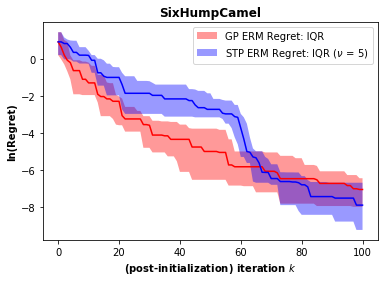

In [610]:
### 10. Visualise!

title = obj_func

plt.figure()

plt.plot(median_gp, color = 'Red')
plt.plot(median_stp, color = 'Blue')

xstar = np.arange(0, 101, step=1)
plt.fill_between(xstar, lower_gp, upper_gp, facecolor = 'Red', alpha=0.4, label='GP ERM Regret: IQR')
plt.fill_between(xstar, lower_stp, upper_stp, facecolor = 'Blue', alpha=0.4, label='STP ERM Regret: IQR ' r'($\nu$' ' = {})'.format(df1))

plt.title(title, weight = 'bold')
plt.xlabel('(post-initialization) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('ln(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

plt.show() #visualise
